<a href="https://colab.research.google.com/github/johramoosa/CS6705-Group8/blob/main/Main_Analysis_MLAMA_JMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
try:
    import google.colab
    # Running on Google Colab, so install Biopython first
    !pip install forestci
    !pip install pmdarima
    !pip install Function
except ImportError:
    pass

In [ ]:
#@title
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')# ,force_remount=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Import Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from statsmodels.genmod.families import Poisson
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.feature_selection import RFE
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import forestci as fci
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
%matplotlib inline
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit#from Function import TimeSeriesSplit
import seaborn as sns
from matplotlib.colors import ListedColormap

from pandas.plotting import autocorrelation_plot

#from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

import datetime



ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
import os
inFoldername_pre = "/content/drive/MyDrive/PHO/MLAMA/Data/"

In [ ]:
#### Read Data

filename = "PHO weekly case.csv"
filename = "PHO weekly case - EXTEND PREDICTION.csv"
df = pd.read_csv(inFoldername_pre+filename,index_col=0)
df.index = df.week # Transferring index as timeline
#df.index = pd.to_datetime(df.index, format = '%m/%d/%Y').strftime("%Y-%m-%d")

data = df.weekcase # single variable data, with index as timeline

In [ ]:
def printmyname():
	print('JMM Package')

In [ ]:
printmyname()

JMM Package


In [ ]:
df_extended = pd.read_csv(inFoldername_pre+"PHO weekly case - EXTEND PREDICTION.csv",index_col=0)

#df = pd.read_csv(inFoldername_pre+"PHO weekly case - EXTEND PREDICTION.csv",index_col=0)
#df.index = df.week # Transferring index as timeline
#data = df.weekcase # single variable data, with index as timeline

In [ ]:
no_wave = 3
history_length = 6

# seperated_wave_data = 0

# wave_date_range = [
#     ['2020-01-12', '2021-02-14'],
#     ['2021-02-28', '2022-02-06'],
#     ['2022-02-20', '2023-09-10']
# ]

# wave_train_range = [

# ]

#make log
#wave_test_range calculate

In [ ]:
# ### Seperating data into different patterns
# # Wave 1
# wave1 = df.loc['2020-01-12':'2021-02-14']#test train ratio??
# train_1 = df.loc['2020-01-12':'2021-01-03']
# test_1 = df.loc['2021-01-10':'2021-02-14']#keep 6 days for history
# ## Wave 2
# wave2 = df.loc['2021-02-28':'2022-02-06']
# train_2 = df.loc['2021-02-28':'2021-12-26']
# test_2 = df.loc['2022-01-02':'2022-02-06']
# ## Wave 3
# wave3 = df.loc['2022-02-20':'2023-09-10']
# train_3 = df.loc['2022-02-20':'2023-07-30']
# test_3 = df.loc['2023-08-06':'2023-09-10']
# ## Entire Dataset
# train = df.loc['2020-01-12':'2023-06-11']
# test = df.loc['2023-06-11':]


# print('wave 3', len(wave3), len(train_3), len(test_3))
# print('entire ', len(train), len(test))

In [ ]:
class Wave:
  def __init__(self, waveID, startDate, endDate,
               trainStartDate, trainEndDate, testStartDate, testEndDate, df):
    self.waveID = waveID
    self.startDate = startDate
    self.endDate = endDate

    self.trainStartDate = trainStartDate
    self.trainEndDate = trainEndDate
    self.testStartDate = testStartDate
    self.testEndDate = testEndDate
    #self.df = df
    self.df = df.loc[self.startDate:self.endDate]

  def print_wave(self):
    print('Wave', self.waveID, ':')
    print('All:', self.startDate, ':', self.endDate)
    print('Train:', self.trainStartDate, ':', self.trainEndDate)
    print('Test:', self.testStartDate, ':', self.testEndDate)

  def get_wave_dates_with_delay(self, delay):
    """
    Args:
      wave:Wave object
    """
    ############WAVE data
    start = datetime.datetime.strptime(self.startDate,"%Y-%m-%d")#start fixed, irrespective of delay
    start_str = start.strftime("%Y-%m-%d")

    e = datetime.datetime.strptime(self.endDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    end = e + w#end delayed
    end_str = end.strftime("%Y-%m-%d")
    #print('Wave:', start_str, ':', end_str)
    wave_data = df.loc[start_str:end_str]

    ############Train data
    start = datetime.datetime.strptime(self.trainStartDate,"%Y-%m-%d")#train start fixed, irrespective of delay
    start_str = start.strftime("%Y-%m-%d")

    e = datetime.datetime.strptime(self.trainEndDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    end = e + w#end delayed
    end_str = end.strftime("%Y-%m-%d")
    #print('Train:', start_str, ':', end_str)
    train_data = df.loc[start_str:end_str]

    ############Test data
    s = datetime.datetime.strptime(self.testStartDate,"%Y-%m-%d")#test start date delayed
    w = datetime.timedelta(weeks=delay)
    start = s + w #test start date delayed
    start_str = start.strftime("%Y-%m-%d")


    e = datetime.datetime.strptime(self.testEndDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    end = e + w#end delayed
    end_str = end.strftime("%Y-%m-%d")
    #print('Test:', start_str, ':', end_str)
    test_data = df.loc[start_str:end_str]

    return wave_data, train_data, test_data

  def get_wave_test_start_date_with_delay(self, delay):
    s = datetime.datetime.strptime(self.trainEndDate,"%Y-%m-%d")#doing according to yushu for now datetime.datetime.strptime(self.testStartDate,"%Y-%m-%d")#test start date delayed
    w = datetime.timedelta(weeks=delay)
    start = s + w #test start date delayed
    start_str = start.strftime("%Y-%m-%d")


    e = datetime.datetime.strptime(self.testEndDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    end = e + w#end delayed
    end_str = end.strftime("%Y-%m-%d")

    return start_str, end_str
  def get_wave_df(self):
    return self.df.loc[self.startDate:self.endDate]


In [ ]:
#needed for extended because date format is different

df['week_str']= df['week'].apply(lambda x: datetime.datetime.strptime(x,"%m/%d/%Y"))

df['weekE']= df['week_str'].apply(lambda x: x.strftime("%Y-%m-%d"))#edited week format for extended file

df.index = df.weekE

In [ ]:
wave1d0 = Wave(1,'2020-01-12', '2021-02-14', '2020-01-12', '2021-01-03', '2021-01-10', '2021-02-14', df)# Wave 1 delay 0

wave2d0 = Wave(2,'2021-02-28', '2022-02-06', '2021-02-28', '2021-12-26', '2022-01-02', '2022-02-06', df)# Wave 2 delay 0

wave3d0 = Wave(3,'2022-02-20', '2023-09-10', '2022-02-20', '2023-07-30', '2023-08-06', '2023-09-10', df)#Wave 3 delay 0


In [ ]:
from scipy.stats import linregress

def slope_calculate(length, y):
    x = range(length)
    slope, intercept, r_value, p_value, std_err = linregress(x, y=y)
    print(slope)
    return slope

In [ ]:
# slope_count_start_date = ['2021-01-03', '2021-12-26', '2023-05-28']
#                           #0=wave1,       1=wave2,      2=wave3 (I changed the dates for wave3)
# slope_count_end_date = ['2021-01-10', '2022-01-02', '2023-06-04']

WAVE1 = 1
WAVE2 = 2
WAVE3 = 3

WAVES = [WAVE1, WAVE2, WAVE3]
WAVES = [wave1d0, wave2d0, wave3d0]

max_delay = 6 #6 weeks delay

tscv1 = TimeSeriesSplit(n_splits = 11,test_size=12)

In [ ]:

#only done for wave1 yet
arima_order = (2,0,0)
arima_seasonal_order = (0,0,0,52)

COLUMN_NAMES = ['wave', 'delay', 'prediction_length','xgb', 'rf', 'xgb_resid', 'xgb_resid_predict','arima', 'xgb_resid_mape', 'xgb_mape', 'arima_list', 'RF_list', 'xgb_list', 'xgb_resid_list']

metrics_df = pd.DataFrame(columns=COLUMN_NAMES)


predictions = [1, 2, 3, 4, 5, 6]
delay_list = [0, 1, 2, 3, 4]#, 5]

weeks = [predictions[i]-1 for i in range(len(predictions))]

print(weeks)


[0, 1, 2, 3, 4, 5]


In [ ]:
# #print(slope_count_start_date[0]+1)
# # datetime test cell
# import datetime
# u = datetime.datetime.strptime(slope_count_start_date[0],"%Y-%m-%d")
# d = datetime.timedelta(weeks=1)
# t = u + d
# tstr = t.strftime("%Y-%m-%d")

# print(tstr)

In [ ]:
for delay in range(0, max_delay-1):
  for WAVE in WAVES:
  ############WAVE1
    #s = datetime.datetime.strptime(slope_count_start_date[WAVE.waveID-1],"%Y-%m-%d")
    s = datetime.datetime.strptime(WAVE.trainStartDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    start = s + w
    start_str = start.strftime("%Y-%m-%d")

    e = datetime.datetime.strptime(WAVE.trainEndDate,"%Y-%m-%d")
    w = datetime.timedelta(weeks=delay)
    end = e + w
    end_str = end.strftime("%Y-%m-%d")
    y_wave = df.loc[start_str:end_str].weekcase
    slope = slope_calculate(len(y_wave),y_wave)# -3488.0
    print('Wave', WAVE.waveID+1, ':', start_str, ':', end_str, len(y_wave), slope)




275.20998036369843
Wave 2 : 2020-01-12 : 2021-01-03 52 275.20998036369843
129.5479210711769
Wave 3 : 2021-02-28 : 2021-12-26 44 129.5479210711769
-198.60821599453178
Wave 4 : 2022-02-20 : 2023-07-30 76 -198.60821599453178
303.08879023307435
Wave 2 : 2020-01-19 : 2021-01-10 52 303.08879023307435
360.4113460183228
Wave 3 : 2021-03-07 : 2022-01-02 44 360.4113460183228
-199.16762816131234
Wave 4 : 2022-02-27 : 2023-08-06 76 -199.16762816131234
318.3242551011697
Wave 2 : 2020-01-26 : 2021-01-17 52 318.3242551011697
530.6774489076815
Wave 3 : 2021-03-14 : 2022-01-09 44 530.6774489076815
-200.01043062200958
Wave 4 : 2022-03-06 : 2023-08-13 76 -200.01043062200958
324.22957397763173
Wave 2 : 2020-02-02 : 2021-01-24 52 324.22957397763173
615.4794926004229
Wave 3 : 2021-03-21 : 2022-01-16 44 615.4794926004229
-200.1642925495557
Wave 4 : 2022-03-13 : 2023-08-20 76 -200.1642925495557
322.5284299496287
Wave 2 : 2020-02-09 : 2021-01-31 52 322.5284299496287
661.3303030303031
Wave 3 : 2021-03-28 : 2022

In [ ]:
#### Function for Statistics Model
def stats_data(df_use):
    # generating covariate for statistics model
    # data - input for ARIMA model (single variate)
    # finaldf_poi - input for other statis models (multivariate)  eg. Poisson, Negative Binomial
    data = pd.DataFrame(df_use.weekcase)
    data.index= df_use.index
    data.index = pd.to_datetime(data.index)
    data = data.reset_index(drop=True)
    data_poi = df_use[["weekcase", "Sin_Time1","Cos_Time1","Sin_Time2","Cos_Time2"]]
    finaldf_poi = data_poi.reset_index(drop=True)
    return data, finaldf_poi

#### Time Series Cross validation
tscv1 = TimeSeriesSplit(n_splits = 11,test_size=12)
#tscv2 = TimeSeriesSplit(n_splits=20,test_size=5, delay=0, force_step_size =12)


In [ ]:
def ARIMA_model(ARMAmodel,test,predict_length,test_length):
    ARMAmodel = ARMAmodel.fit()
    y_pred = ARMAmodel.get_forecast(len(test))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] ### Prediction of ARIMA model
    arima_mse = mean_squared_error(test,y_pred_out) ### Calculate MSE
    arima_rmse = np.sqrt(mean_squared_error(test,y_pred_out)) ### Calculate rMSE
    arima_mae = mean_absolute_error(test,y_pred_out) ### Calculate MAE
    arima_mape = mean_absolute_percentage_error(test,y_pred_out) ### Calculate the MAPE
    arima_list = np.array(np.abs(np.array(y_pred_out)-np.transpose(np.array(test)))/np.transpose(np.array(test))) ### Calculate the APE for each prediction value
    arimap= y_pred_df["Predictions"] # length - test_length
    arimaf = ARMAmodel.fittedvalues.tail(predict_length-test_length) # length 25
    arima = pd.concat([arimaf,arimap],axis=0) ### Combine fitting value with prediction value
    return arima_mse, arima_rmse,arima_mae,arima_mape, arima_list,arima

In [ ]:
#### Function for Machine Learning Model
def gen_ml(data,test_length,parameter_length,resid):
    dataframe = pd.DataFrame()
    for i in range(parameter_length, 0, -1):
        dataframe['t+' + str(i)] = data.weekcase.shift(i)
    final_data = pd.concat([data,dataframe], axis=1)
    final_data.dropna(inplace=True)
    finaldf = final_data
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(final_data.index)
    if resid == False :
        x = end_point - 6
    else:
        x = end_point - test_length
    finaldf_test = finaldf.loc[x:x+test_length-1,:]
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'weekcase']
    finaldf_test_y = finaldf_test['weekcase']
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'weekcase']
    finaldf_train_y = finaldf_train['weekcase']
    return finaldf_train_x,finaldf_test_x,finaldf_train_y,finaldf_test_y

def ml_model(test_x,test_y,model,data):
    predict = model.predict(test_x) # prediction
    list = np.abs(predict - test_y)/test_y # MAPE for each prediction value
    mse = mean_squared_error(data['weekcase'][-len(predict):].values,predict[:]) # MSE for prediction model
    rmse = sqrt(mean_squared_error(data['weekcase'][-len(predict):].values,predict[:]))
    mae = mean_absolute_error(data['weekcase'][-len(predict):].values,predict[:])
    mape = mean_absolute_percentage_error(data['weekcase'][-len(predict):].values,predict[:])
    return list,mse,rmse,mae,mape

In [ ]:
#### Prepare for Esemble Model
def arima_res_xgb(ARMAmodel,data,train,test_length,test,fit_length,cv,resid,booster,learning_rate, n_estimator):
    data_length = len(train) + test_length
    arima_mse, arima_rmse,arima_mae,arima_mape, arima_list,arima = ARIMA_model(ARMAmodel,test,data_length,test_length)
    residual =  data.reset_index(drop = True).head(len(arima)).sub(arima.reset_index(drop = True),axis = 0) ## Residual = Real value - Fitted/Predicted
    finaldf_train_resid_x,finaldf_test_resid_x,finaldf_train_resid_y,finaldf_test_resid_y = gen_ml(residual,test_length,cv,resid)
    xgb_resid = XGBRegressor(booster = booster, learning_rate = learning_rate, n_estimator = n_estimator).fit(finaldf_train_resid_x, finaldf_train_resid_y)
    xgb_resid_predict1 = xgb_resid.predict(finaldf_test_resid_x) #Predictions on Testing data
    A =(arima.reset_index(drop = True).tail(test_length) + xgb_resid_predict1)# Adding predicted residual on the predictted ARIMA value
    xgb_resid_list= np.abs(A.reset_index(drop = True)- test.weekcase)/ test.weekcase
    xgb_resid_p = A.reset_index(drop=True)
    xgb_resid_f = pd.DataFrame(xgb_resid.predict(finaldf_train_resid_x))
    xgb_resid_f = xgb_resid_f.add(pd.DataFrame(arima).tail(-5).reset_index(drop=True))
    xgb_resid_f  = xgb_resid_f.head(-test_length)
    xgb_resid_f = xgb_resid_f.tail(26).reset_index(drop=True)
    xgb_resid = pd.concat([xgb_resid_f, xgb_resid_p], axis=0)
    return xgb_resid, xgb_resid_predict1,arima, xgb_resid_list

def replace_negatives(x):
    if x < 0:
        return 0
    else:
        return x

In [ ]:
tuned_model_names = ['ARIMA', 'XGB_42', 'forest_42', 'XGB', 'res', 'forest']


tuned_model_dict = {}

for name in tuned_model_names:
    param_filename = inFoldername_pre+name+'_param_tunning_'+filename
    #param_filename = inFoldername_pre+'Martin/'+name+'_param_tunning.csv'
    data = pd.read_csv(param_filename)
    for wave_delay in data['Dataset']:
      tuned_model_dict[wave_delay+name] = data.loc[data['Dataset']==wave_delay]
      tuned_model_dict[wave_delay+name] = tuned_model_dict[wave_delay+name].drop(columns=['Dataset'])
      print(tuned_model_dict[wave_delay+name])

   maxiter method      order  out_of_sample_size scoring scoring_args  \
0       50  lbfgs  (1, 0, 1)                   0     mse           {}   

  seasonal_order  start_params  suppress_warnings  trend  with_intercept  
0  (0, 0, 0, 52)           NaN               True    NaN           False  
   maxiter method      order  out_of_sample_size scoring scoring_args  \
1       50  lbfgs  (1, 0, 1)                   0     mse           {}   

  seasonal_order  start_params  suppress_warnings  trend  with_intercept  
1  (0, 0, 0, 52)           NaN               True    NaN           False  
   maxiter method      order  out_of_sample_size scoring scoring_args  \
2       50  lbfgs  (1, 0, 1)                   0     mse           {}   

  seasonal_order  start_params  suppress_warnings  trend  with_intercept  
2  (0, 0, 0, 52)           NaN               True    NaN           False  
   maxiter method      order  out_of_sample_size scoring scoring_args  \
3       50  lbfgs  (1, 0, 1)        

In [ ]:
#### Prediction on Wave 1,2,3 Data [Prediction 1,2,3,4,5,6 weeks]
### Example Code: Wave 1 with prediction length = 1
# Model. ARIMA
#make a fucntion, incorporate delay

#tuned_model_dict contains param for specific delay, wave all models

def wave_prediction(prediction_length, wave, train, test, tuned_model_dict):
  """

  Args:
    prediction_length:
    wave:
    train:
    test:
  """


  single_train, full_train = stats_data(train)
  ### Wave 1 week looped
  single_test, full_test = stats_data(test.head(prediction_length))
  #### Will do both for tscv1 and tscv2
  tuned_model_name = 'res'
  key = 'wave '+str(wave)+' delay '+str(delay)+tuned_model_name
  key = tuned_model_name
  tuned_params = tuned_model_dict[key]

  tuned_model_name = 'ARIMA'
  key = 'wave '+str(wave)+' delay '+str(delay)+tuned_model_name
  key = tuned_model_name
  arima_order = tuned_model_dict[key]['order'].iloc[0]
  arima_seasonal_order = tuned_model_dict[key]['seasonal_order'].iloc[0]
  arima_order_list = ()
  arima_seasonal_order_list = ()
  s = arima_order.split(',')#because its a string

  arima_order_list = (int(s[0].split('(')[1]),int(s[1]),int(s[2].split(')')[0]))

  s = arima_seasonal_order.split(',')
  arima_seasonal_order_list = (int(s[0].split('(')[1]),int(s[1]),int(s[2]),int(s[3].split(')')[0]))

  #print(arima_order_list)
  #print(arima_seasonal_order_list)


  ARMAmodel = SARIMAX(single_train,order=arima_order_list,seasonal_order=arima_seasonal_order_list)# change in order (2, 0, 1) for delaay =0
  arima_mse,arima_rmse,arima_mae,arima_mape,arima_list,arima = ARIMA_model(ARMAmodel,single_test,26+prediction_length,len(single_test))

  ### Generate Machine Learning Data
  train_x,test_x,train_y,test_y = gen_ml(pd.DataFrame(wave.weekcase),prediction_length,5,resid = False)
  #### Random Forest Model
  tuned_model_name = 'forest_42'
  key = 'wave '+str(wave)+' delay '+str(delay)+tuned_model_name
  key = tuned_model_name
  max_depth = tuned_model_dict[key]['max_depth'].iloc[0]
  max_features = tuned_model_dict[key]['max_features'].iloc[0]
  min_samples_split = tuned_model_dict[key]['min_samples_split'].iloc[0]
  n_estimators = tuned_model_dict[key]['n_estimators'].iloc[0]

  RF_model = RandomForestRegressor(max_depth =max_depth, max_features= max_features,min_samples_split = min_samples_split, n_estimators= n_estimators,random_state= 42).fit(train_x,train_y)
  RF_list,rf_mse,rf_rmse,rf_mae,rf_mape = ml_model(test_x,test_y,RF_model,train)
  rf_fit = pd.DataFrame(RF_model.predict(train_x)).reset_index(drop = True).tail(26)
  rf_pre = pd.DataFrame(RF_model.predict(test_x)).reset_index(drop = True)
  rf = pd.concat([rf_fit,rf_pre],axis=0)

  #### XGBoost Model
  tuned_model_name = 'XGB'
  key = 'wave '+str(wave)+' delay '+str(delay)+tuned_model_name
  key = tuned_model_name
  booster = tuned_model_dict[key]['booster'].iloc[0]
  learning_rate = tuned_model_dict[key]['learning_rate'].iloc[0]
  n_estimators = tuned_model_dict[key]['n_estimators'].iloc[0]

  xgb =  XGBRegressor(booster = booster, learning_rate = learning_rate, n_estimators = n_estimators).fit(train_x,train_y)
  xgb_predict = xgb.predict(test_x) #Predictions on test_1ing data
  xgb_list = np.abs(xgb_predict - test_y)/test_y
  xgb_p =  pd.DataFrame(xgb_predict)
  xgb_p = xgb_p.reset_index(drop = True)
  xgb_f = xgb.predict(train_x)
  xgb_f = pd.DataFrame(xgb_f).tail(26)
  xgb_f = xgb_f.reset_index(drop=True)
  xgb = pd.concat([xgb_f,xgb_p],axis=0)
  #xgb_2 = pd.concat([xgb_f2,fees],axis=1)
  xgb_mape = mean_absolute_percentage_error(wave.weekcase[-len(xgb_predict):].values,xgb_predict[:])
  #### XGBoost On ARIMA residual
  xgb_resid, xgb_resid_predict,arima, xgb_resid_list = arima_res_xgb(ARMAmodel, pd.DataFrame(wave.weekcase),single_train,prediction_length,single_test,26+prediction_length,5,resid = True, booster = "gbtree", learning_rate = 0.05, n_estimator = 2)
  xgb_resid_mape = mean_absolute_percentage_error(wave.weekcase[-len(xgb_resid_predict):].values,xgb_resid_predict[:]+arima.tail(prediction_length))

  arima_df = pd.DataFrame(arima, columns=['arima'])
  return xgb, rf, xgb_resid, xgb_resid_predict, arima_df, arima_mape, xgb_resid_mape, xgb_mape, rf_mape, arima_list, RF_list, xgb_list, xgb_resid_list

In [ ]:
#arima_order = (2,0,0)
#arima_seasonal_order = (0,0,0,52)

#waveID = 1

for WAVE in WAVES:
  waveID = WAVE.waveID

  for prediction_length in predictions:
    wave_delay_tuned_params = {}
    #print(prediction_length)
    for delay in delay_list:#all delay done here
      for tuned_model_name in tuned_model_names:
        wave_delay_model_key = 'wave '+str(waveID)+' delay '+str(delay)+tuned_model_name
        wave_delay_tuned_params[tuned_model_name]=tuned_model_dict[wave_delay_model_key]

      wave, train, test = WAVE.get_wave_dates_with_delay(delay)
      xgb, rf, xgb_resid, xgb_resid_predict, arima, arima_mape, xgb_resid_mape, xgb_mape, rf_mape, arima_list, RF_list, xgb_list, xgb_resid_list =  wave_prediction(
          prediction_length, wave, train, test, wave_delay_tuned_params)

      xgb = xgb.reset_index(drop = True)
      #print(xgb.shape)
      rf = rf.reset_index(drop = True)
      xgb_resid = xgb_resid.reset_index(drop = True)
      arima = arima.reset_index(drop = True)

      #print(xgb.head())
      data = { 'wave': waveID, 'delay': delay, 'prediction_length':prediction_length,'xgb': [xgb], 'rf': [rf], 'xgb_resid': [xgb_resid], 'xgb_resid_predict': [xgb_resid_predict],'arima': [arima], 'xgb_resid_mape': [xgb_resid_mape], 'xgb_mape':[xgb_mape], 'arima_list' : [arima_list], 'RF_list':[RF_list], 'xgb_list':[xgb_list], 'xgb_resid_list': [xgb_resid_list]}
      #print(data)
      newrow = pd.DataFrame(data)
      #print(newrow.size)
      metrics_df = pd.concat([metrics_df, newrow])#, ignore_index=True





In [ ]:
def process_metrics_df(WAVE, frame):#cloumn_name
  #print(frame)
  metrics_df = pd.concat(frame, axis = 1).tail(32)
  #print(metrics_df.head())
  #metrics_df.columns = cloumn_name
  metrics_df.reset_index(drop=True)
  metrics_df.index = WAVE.get_wave_df().tail(32).index#to get the week as index
  metrics_df= metrics_df.applymap(replace_negatives)
  return metrics_df

In [ ]:
A_dict = {}
B_dict = {}
C_dict = {}
D_dict = {}


#WAVES = [wave1d0]

In [ ]:
for WAVE in WAVES:#[wave2d0]:#
  waveID = WAVE.waveID
  #print(waveID)
  for delay in delay_list:
    #print(delay)
    frame_xgb = []
    frame_xgb_col_name = []

    frame_rf = []
    frame_rf_col_name = []

    frame_xgb_resid = []
    frame_xgb_resid_col_name = []

    frame_xgb_resid_predict = []
    frame_xgb_resid_predict_col_name = []

    frame_arima = []
    frame_arima_col_name = []

    frame_xgb_resid_mape = []
    frame_xgb_resid_mape_col_name = []

    frame_xgb_mape = []
    frame_xgb_mape_col_name = []

    for prediction_length in predictions:
      #print(prediction_length)
      #A
      xgb = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['xgb'].values[0]
      xgb.columns = ['xgb_'+str(prediction_length)]
      frame_xgb = frame_xgb+[xgb]
      #print(xgb.head())
      #frame_xgb_col_name = frame_xgb_col_name+['xgb_'+str(prediction_length)]
      #B
      #print('ARIMA')
      arima = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['arima'].values[0]
      arima.columns = ['arima_'+str(prediction_length)]
      #print(arima.columns)
      #print(arima.head())
      frame_arima = frame_arima+[arima]

      #frame_arima_col_name = frame_arima_col_name+['arima_'+str(prediction_length)]
      #C
      xgb_resid = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['xgb_resid'].values[0]
      xgb_resid.columns = ['xgb_resid_'+str(prediction_length)]

      frame_xgb_resid = frame_xgb_resid+[xgb_resid]
      #frame_xgb_resid_col_name = frame_xgb_resid_col_name+['xgb_resid_'+str(prediction_length)]
      #D
      #print('RF')
      rf = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['rf'].values[0]
      rf.columns = ['rf_'+str(prediction_length)]
      #print(rf.columns)
      #print(rf.head())
      frame_rf = frame_rf+[rf]
      #frame_rf_col_name = frame_rf_col_name+['rf_'+str(prediction_length)]
    wave, train, test = WAVE.get_wave_dates_with_delay(delay)
    time = WAVE.get_wave_df().tail(32).reset_index(drop = True)############need to correxr it
    A = process_metrics_df(WAVE, frame_xgb)#frame_xgb_col_name
    A= A.applymap(replace_negatives)
    A_dict [waveID] = A
    #print(A.head())

    B = process_metrics_df(WAVE, frame_arima)#frame_arima_col_name
    B= B.applymap(replace_negatives)
    B_dict [waveID] = B
    #print(B.head())

    C = process_metrics_df(WAVE, frame_xgb_resid)#frame_xgb_resid_col_name
    C= C.applymap(replace_negatives)
    C_dict [waveID] = C
    #print(C.head())

    D = process_metrics_df(WAVE, frame_rf)#frame_rf_col_name
    D= D.applymap(replace_negatives)
    D_dict [waveID] = D
    #print(D.head())



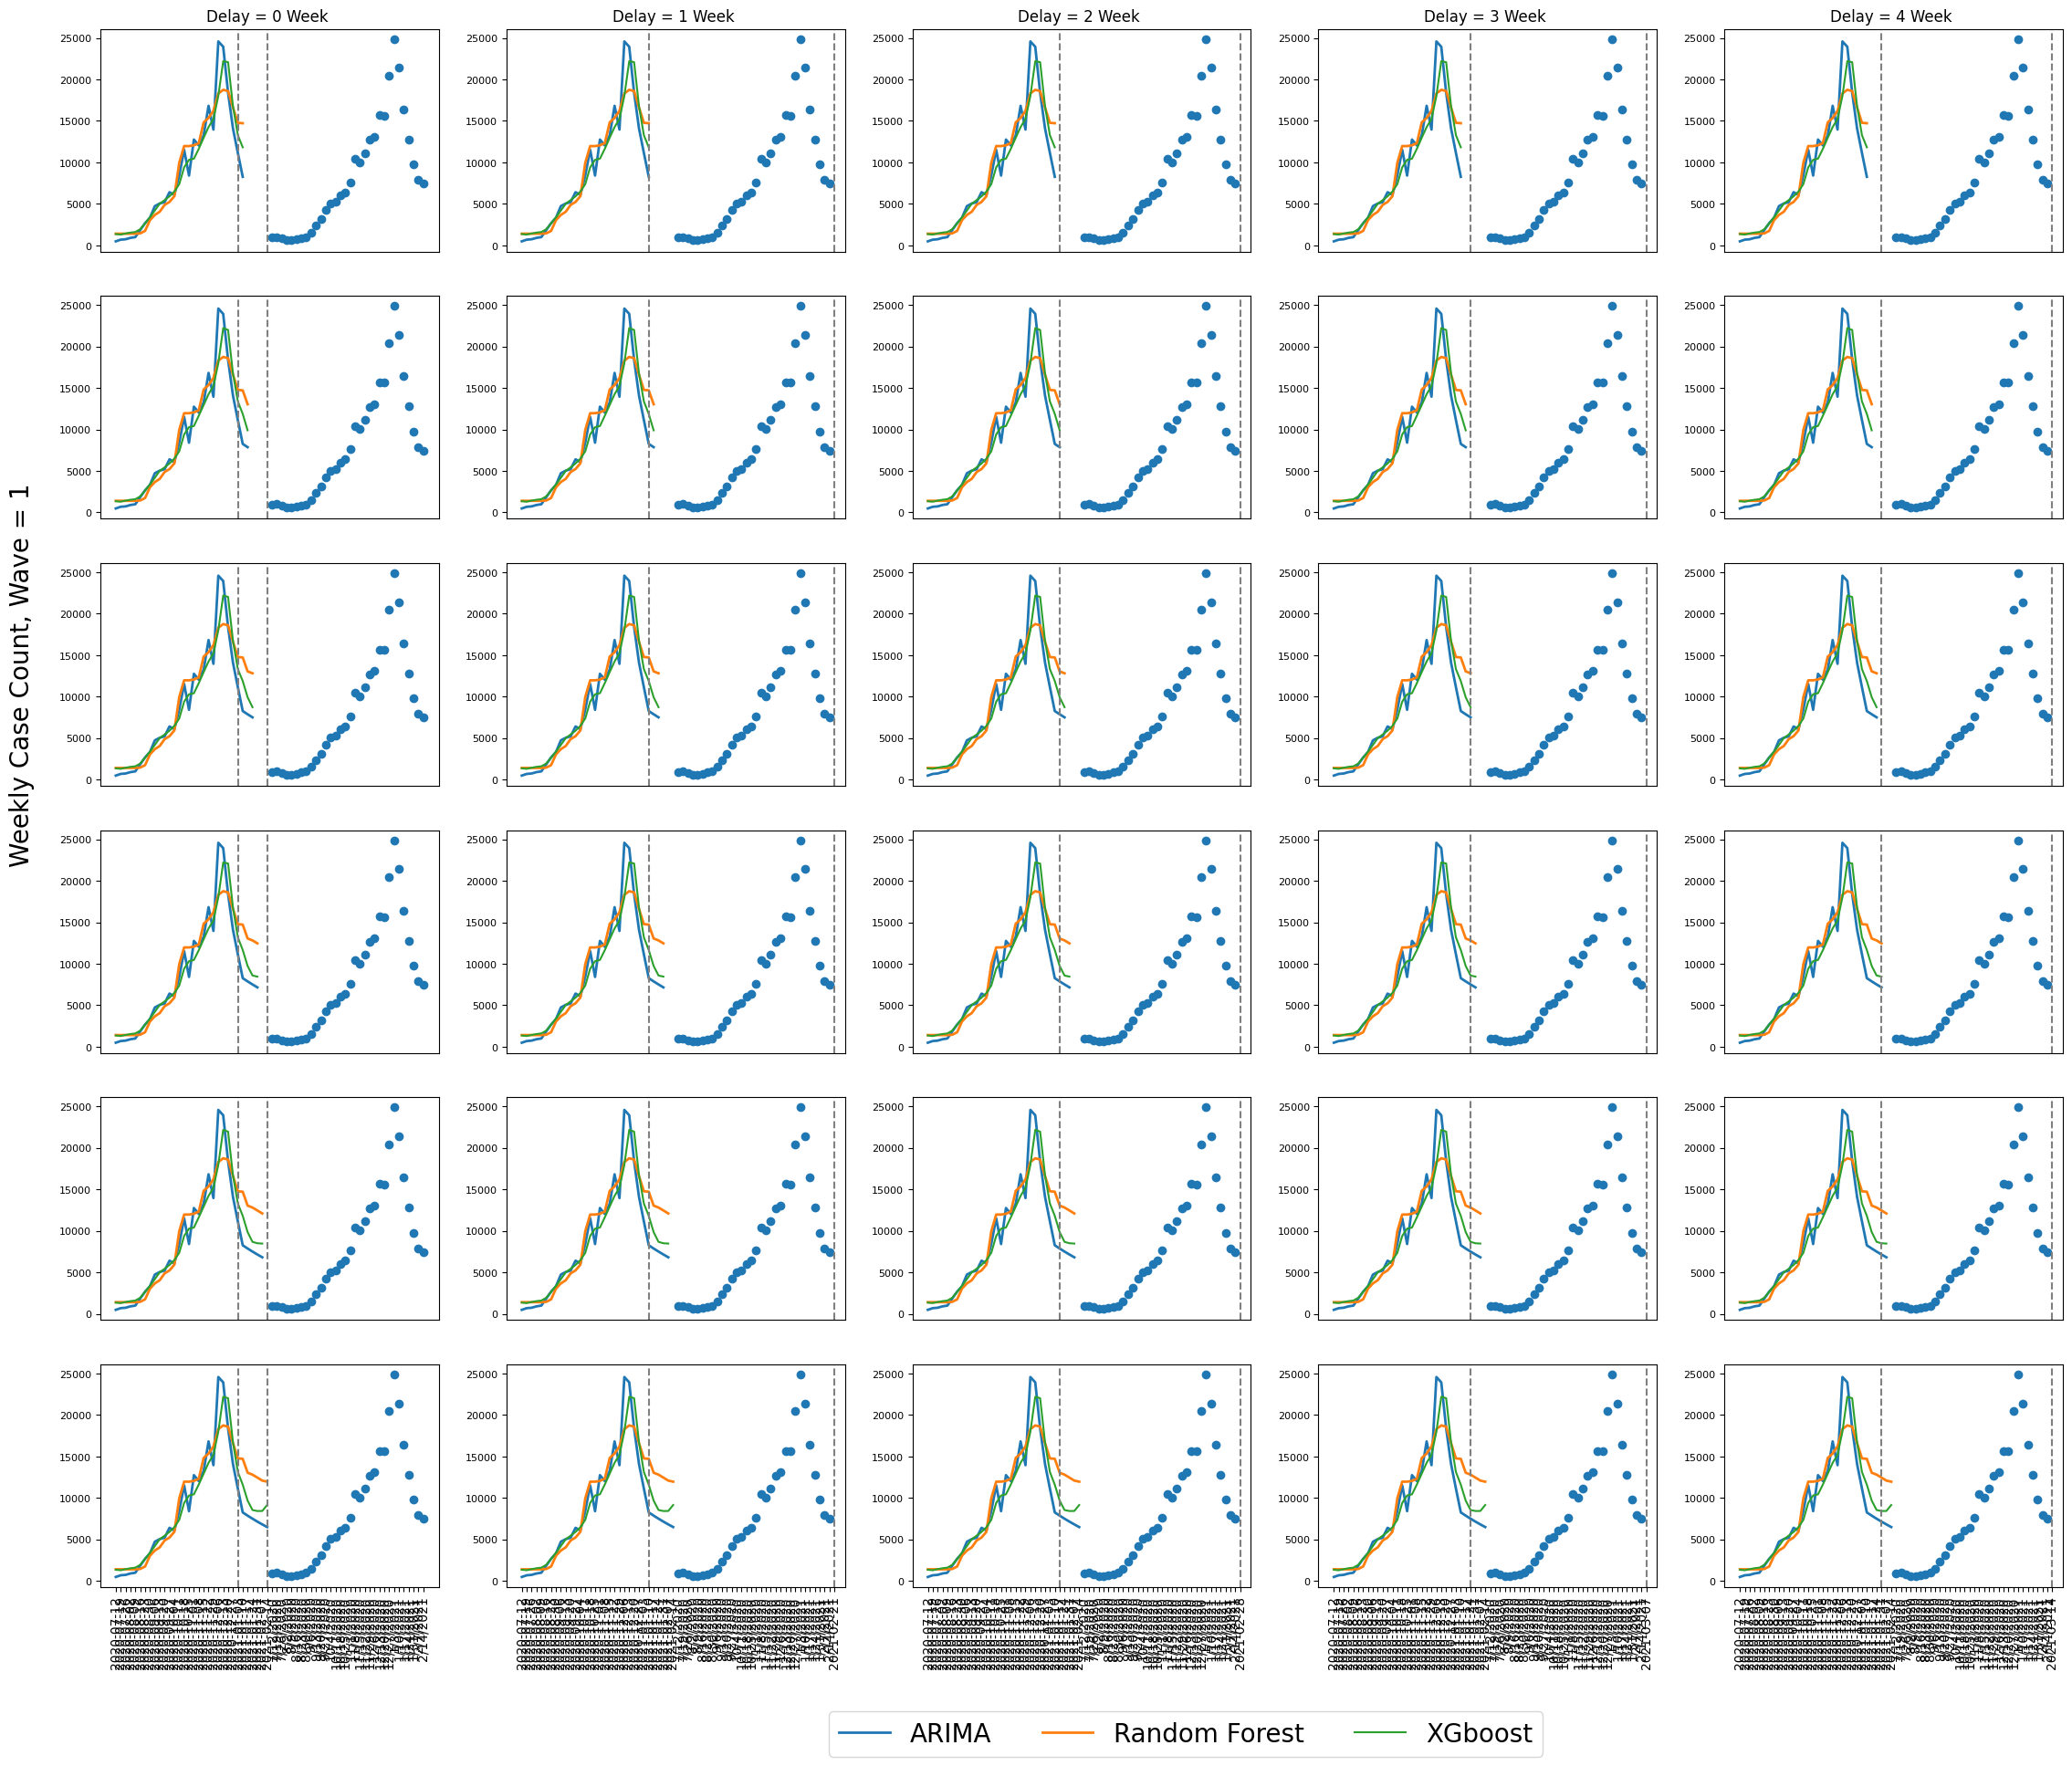

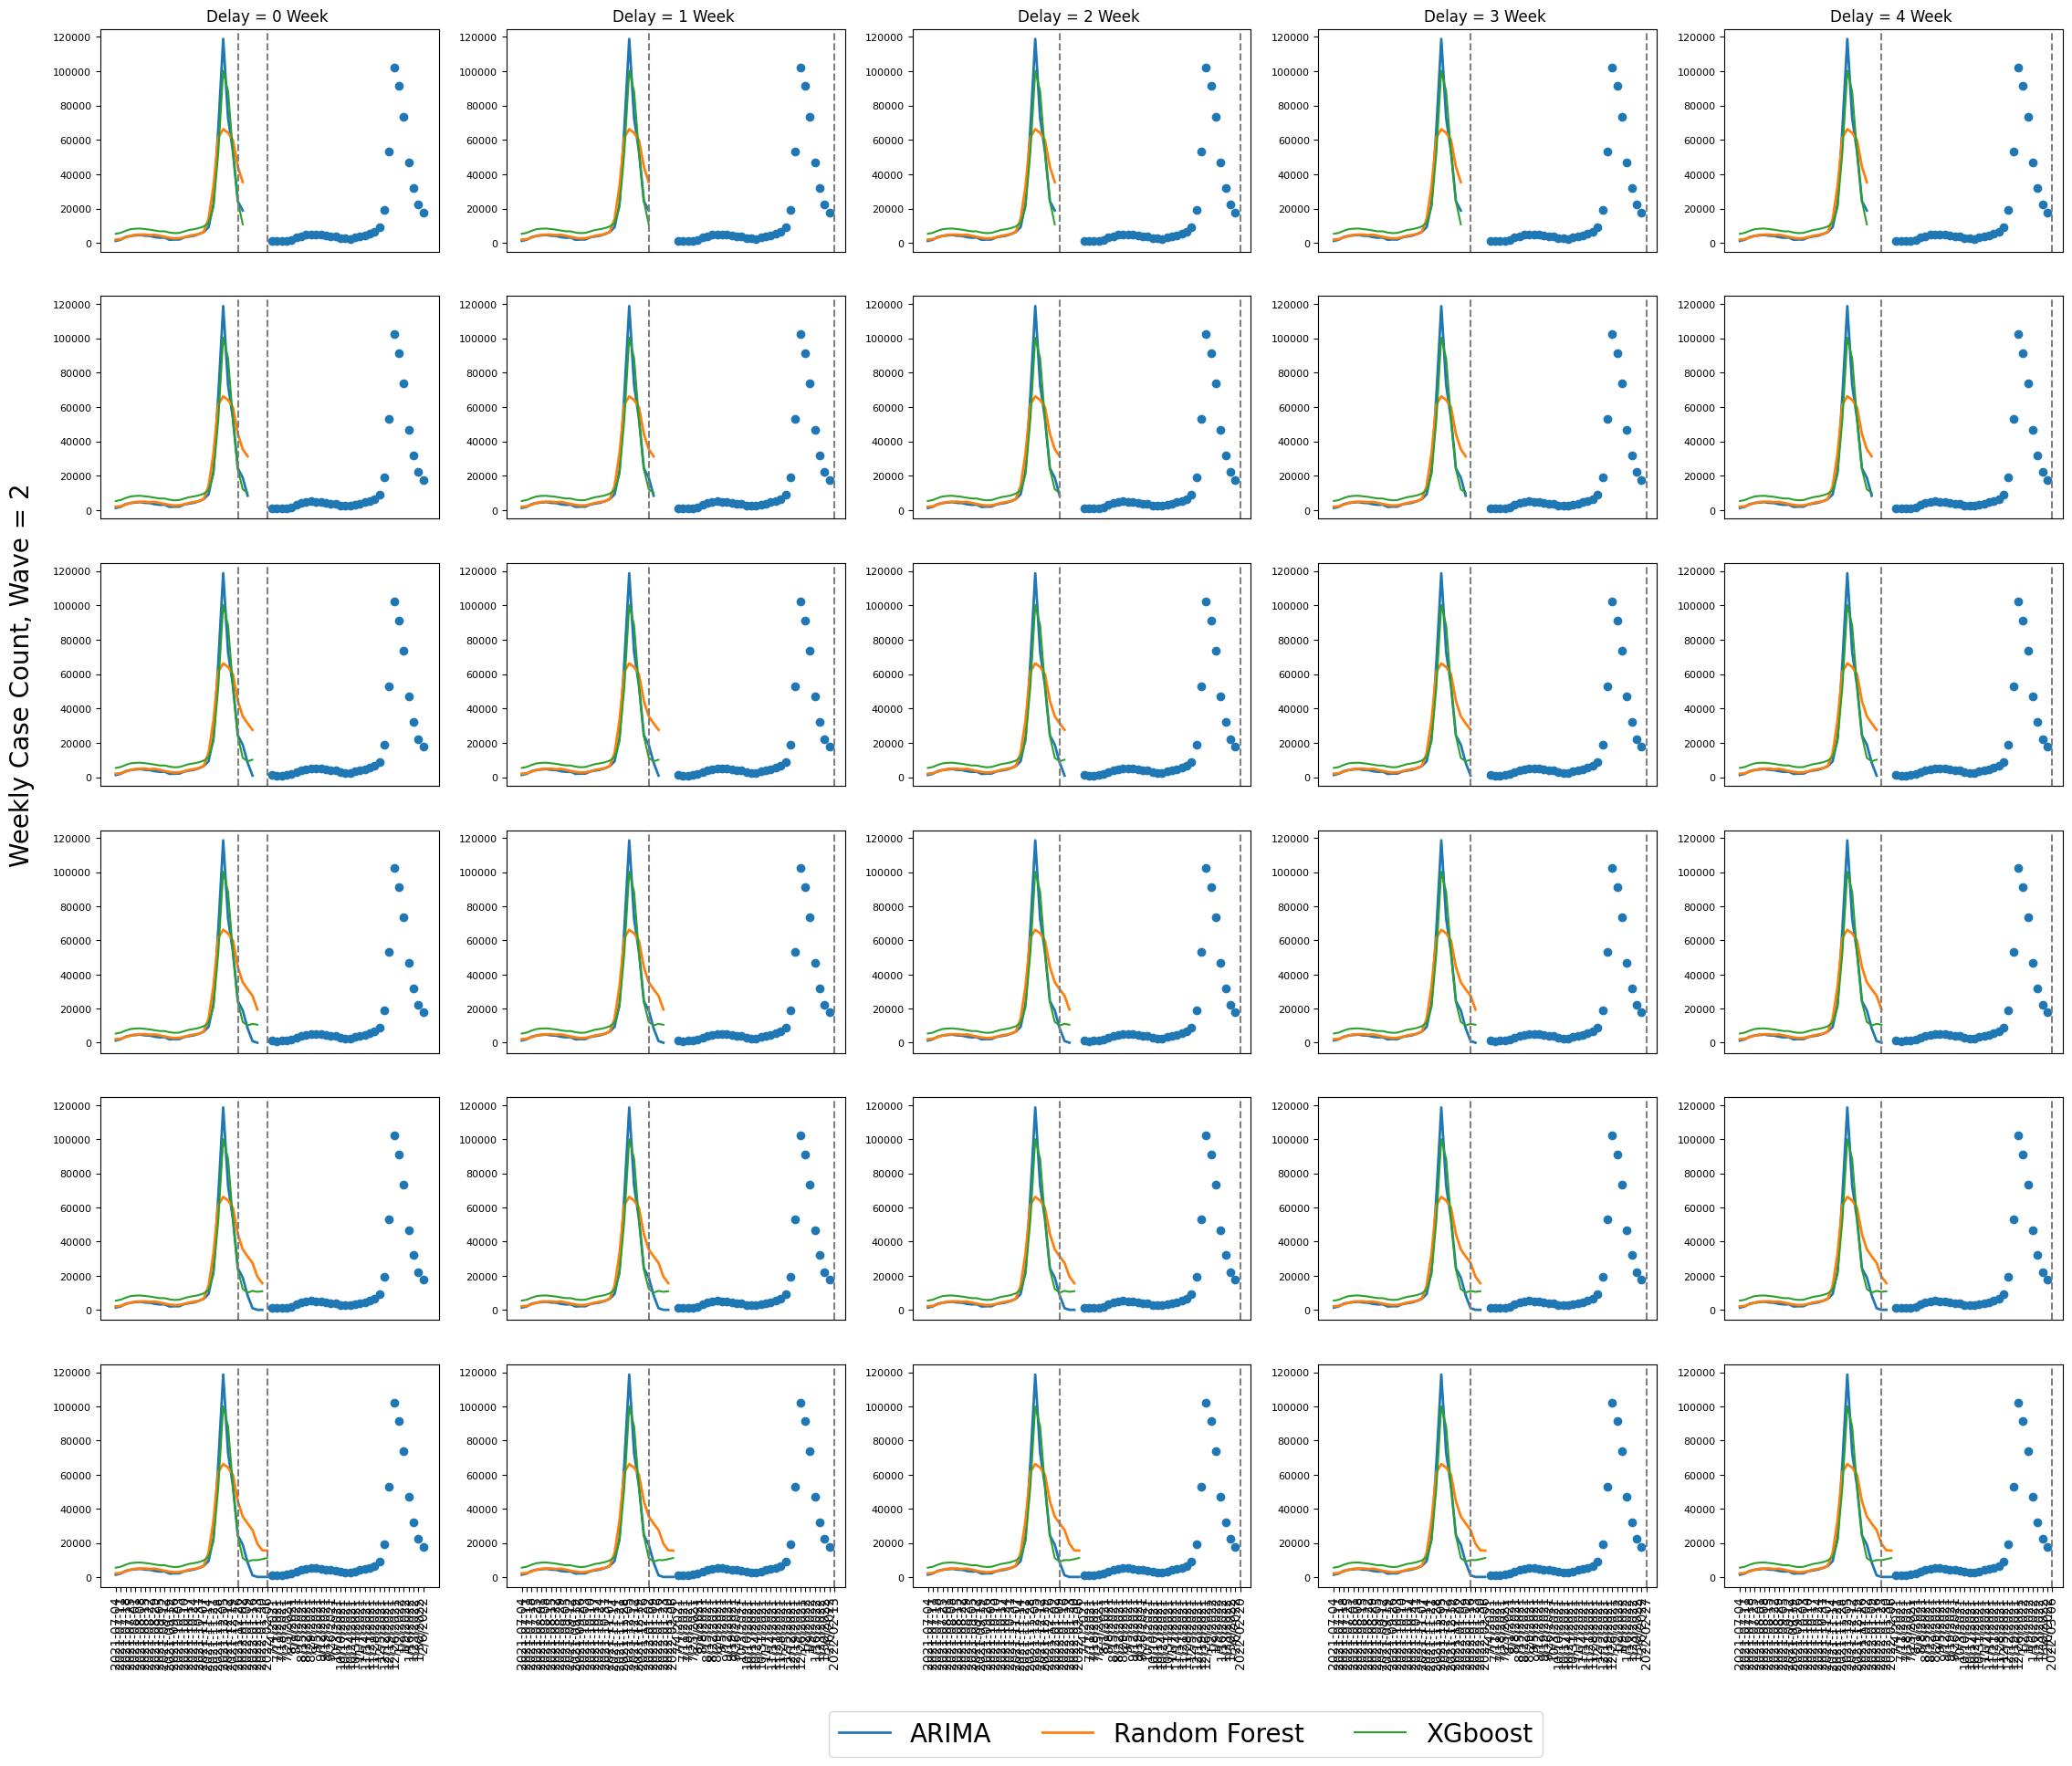

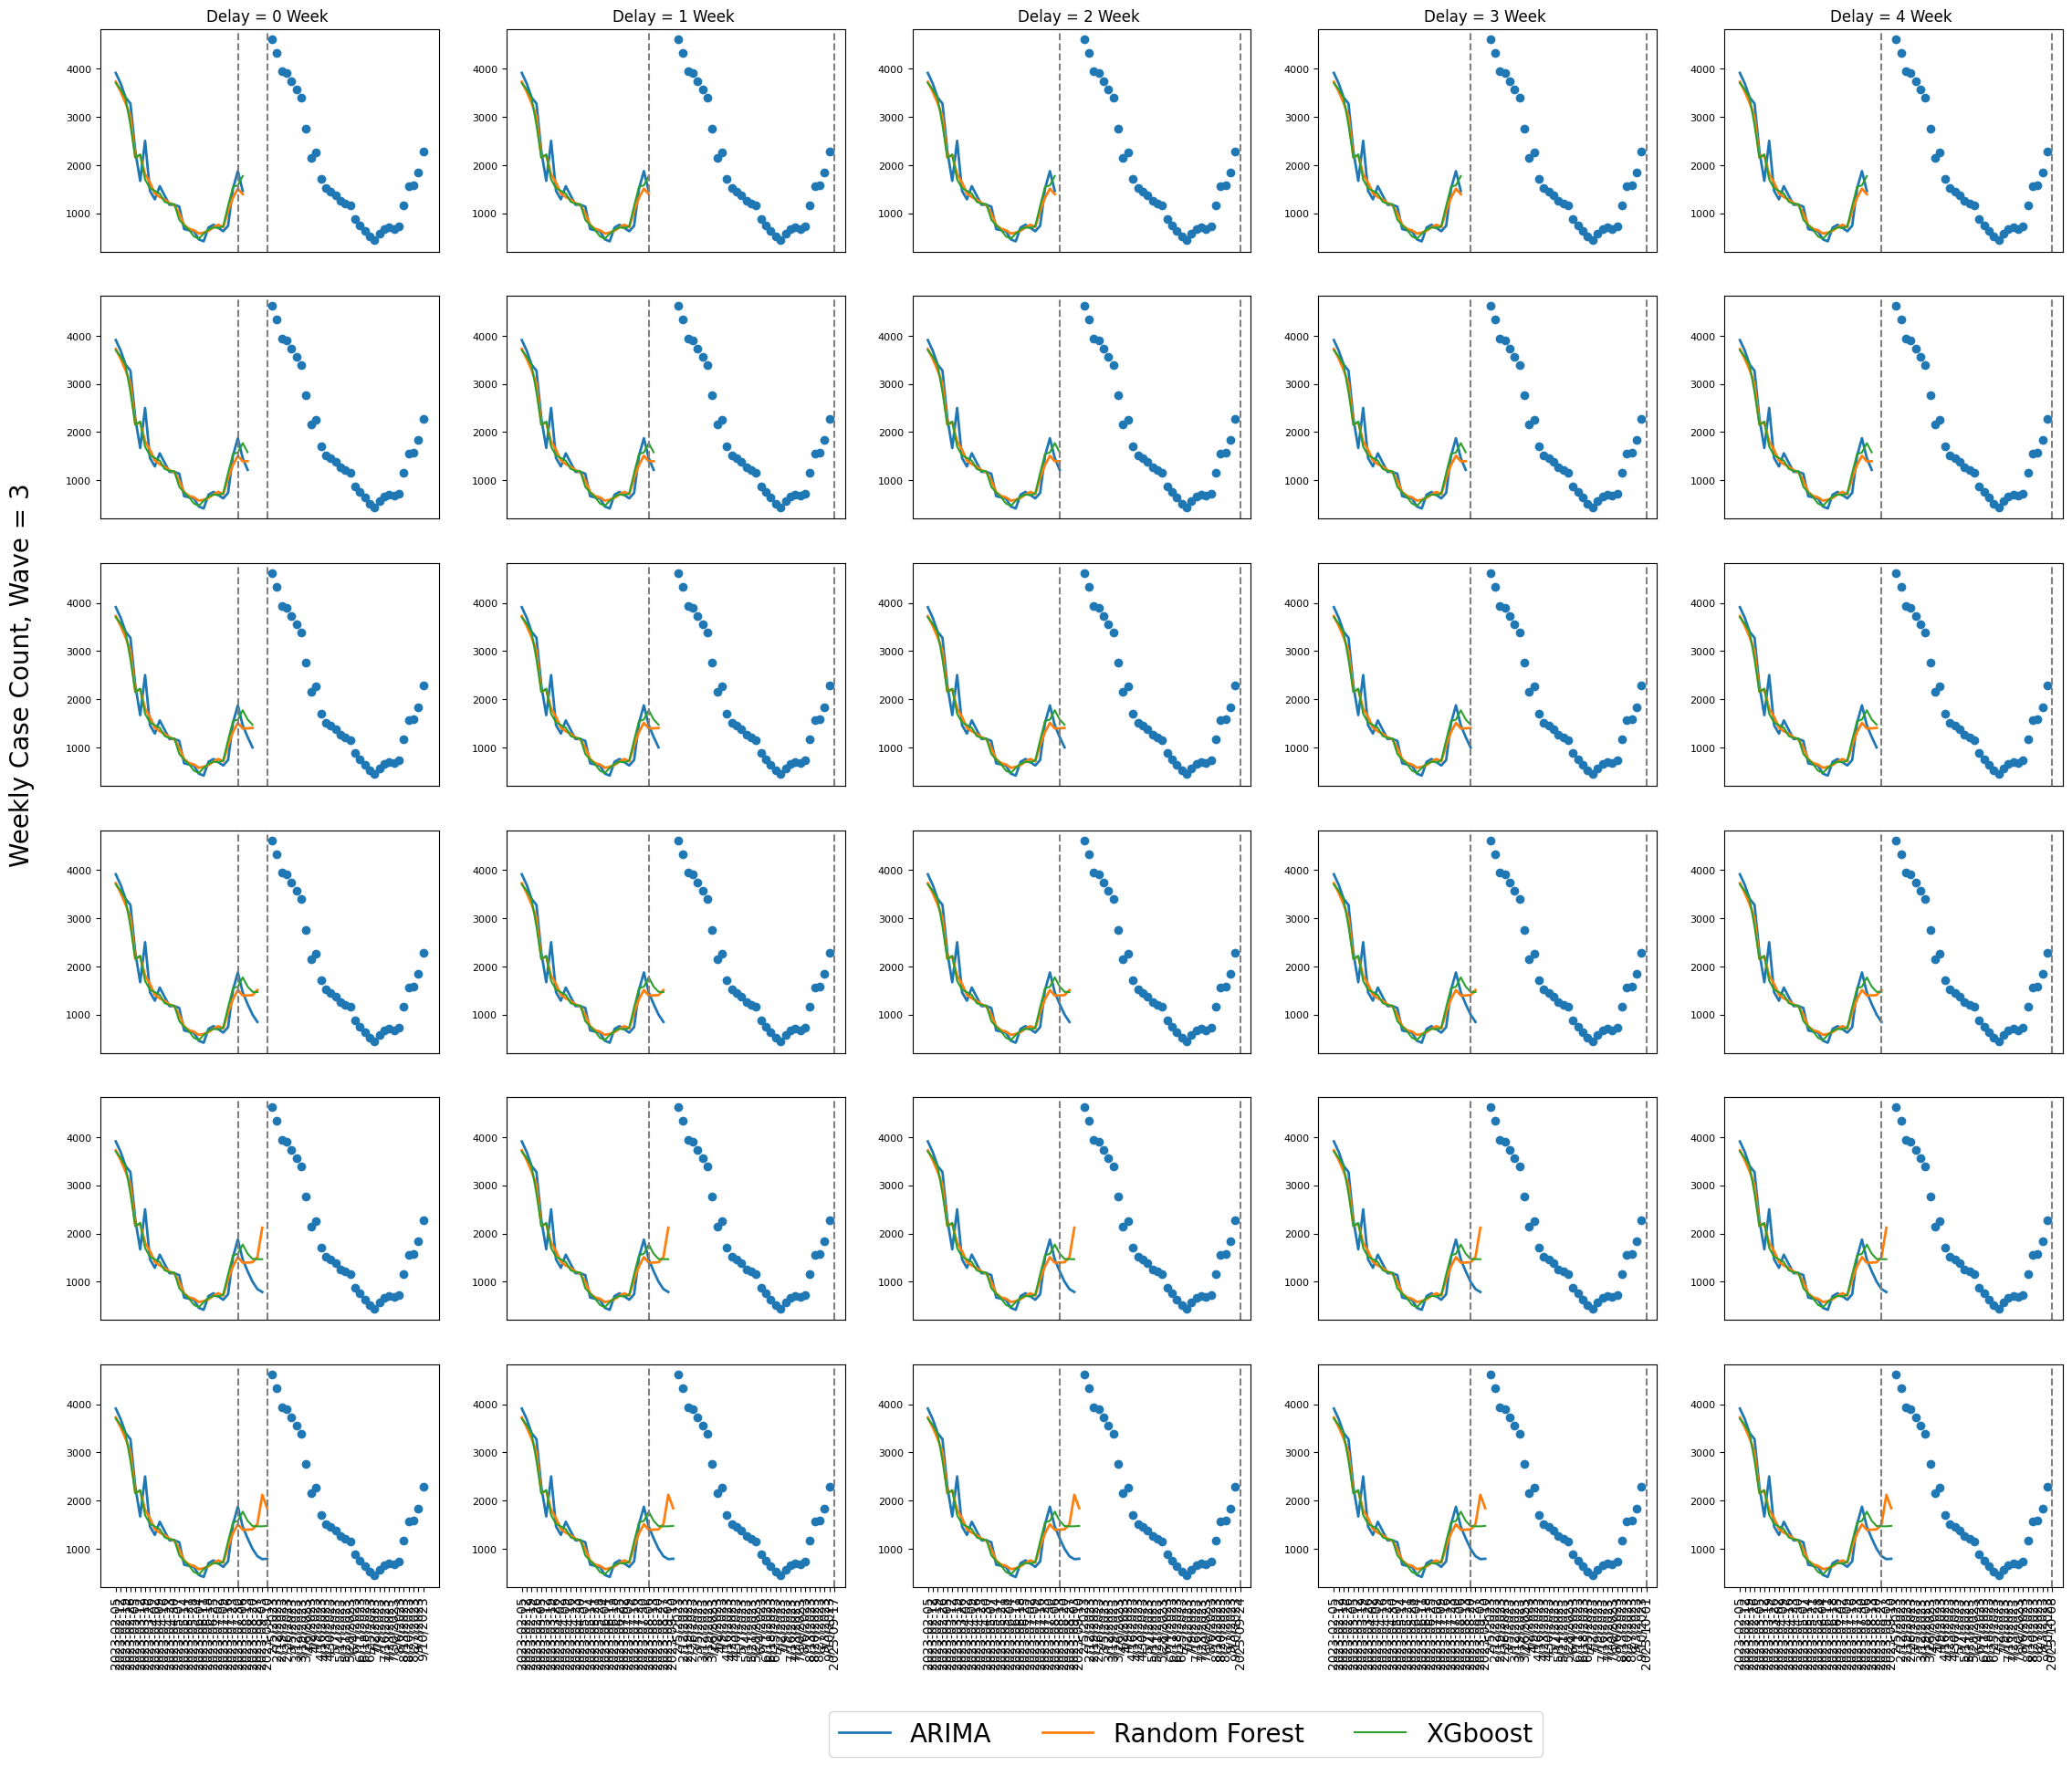

In [ ]:
for WAVE in WAVES:#[wave2d0]:#
  waveID = WAVE.waveID

  fig = plt.figure(figsize = (25,25))
  gs = fig.add_gridspec(prediction_length+1, delay+1, hspace=0.2, wspace=0.2)#7, 6
  time = WAVE.get_wave_df().tail(32).reset_index(drop = True)
  A = A_dict [waveID]
  B = B_dict [waveID]
  C = C_dict [waveID]
  D = D_dict [waveID]
  #print(A.head())
  #print(B.head())
  #print(C.head())
  #print(D.head())

  for delay in delay_list:
    #print('DELAY:', delay)
    from_date, to_date = WAVE.get_wave_test_start_date_with_delay(delay)

    #print(from_date, to_date)
    for prediction_length in predictions:
      #print(prediction_length)
      ax = fig.add_subplot(gs[prediction_length, delay])
      plt.subplots_adjust(left= 0.04, right=0.9, top=0.9, bottom=0.1)
      ax.plot(B.filter(like='_'+str(prediction_length), axis=1), label = "ARIMA", linewidth = 2)
      ax.plot(D.filter(like='_'+str(prediction_length), axis=1), label = "Random Forest", linewidth = 2)
      ax.plot(A.filter(like='_'+str(prediction_length), axis=1), label = "XGboost")
      # ax_1.plot(C.filter(like='_1', axis=1), label = "XGboost_ARIMA")
      ax.scatter(time['week'],time['weekcase'])
      ax.tick_params(axis="y", labelsize=8)
      #ax.legend(bbox_to_anchor=(3.5,-5.3),ncol = 4,fontsize = 20)
      ax.axvline(x=from_date, color='grey',linestyle ="--")
      ax.axvline(x=to_date, color='grey',linestyle ="--")

      if (prediction_length==1): ax.set_title("Delay = "+str(delay)+" Week ")
      if (prediction_length==6): ax.tick_params(axis='x', labelrotation=90)
      else:
        ax.set_xticklabels([])
        ax.set_xticks([])
  ax.legend(bbox_to_anchor=(-0.5,-0.5),ncol = 4,fontsize = 20)

  fig.text(0, 0.5, 'Weekly Case Count, Wave = '+str(waveID), va='center', rotation='vertical', fontsize = "20")
  plt.show()

In [ ]:
weeks

[0, 1, 2, 3, 4, 5]

In [ ]:
df_xgb_list_all_week_delay_wave_collection = {}

df_arima_list_all_week_delay_wave_collection = {}
df_rf_list_all_week_delay_wave_collection = {}
df_xgb_resid_list_all_week_delay_wave_collection = {}

for WAVE in WAVES:#[wave2d0]:#
  waveID = WAVE.waveID

  df_xgb_list_all_week_delay_collection = {}

  df_arima_list_all_week_delay_collection = {}
  df_rf_list_all_week_delay_collection = {}
  df_xgb_resid_list_all_week_delay_collection = {}




  for delay in delay_list:
    print('DELAY:', delay)
    all_week_xgb_list = []
    all_week_arima_list = []
    all_week_rf_list = []
    all_week_xgb_resid_list = []
    for week in weeks:
      print('WEEK:', week)
      week_xgb_list = []
      week_arima_list = []
      week_rf_list = []
      week_xgb_resid_list = []
      for prediction_length in predictions:
        print('PREDICTION LENGTH: ', prediction_length)
        weekly_xgb_delay = np.nan
        weekly_arima_delay = np.nan
        weekly_rf_delay = np.nan
        weekly_xgb_resid_delay = np.nan

        if(prediction_length>week):
          xgb_list = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['xgb_list']
          print(len(np.array(xgb_list[0])))
          weekly_xgb_delay = np.array(xgb_list[0])[week]/(prediction_length)*100
          arima_list = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['arima_list']
          weekly_arima_delay = np.transpose(np.array(arima_list[0][0])[week]/(prediction_length))*100
          rf_list = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['RF_list']
          weekly_rf_delay = np.array(rf_list[0])[week]/(prediction_length)*100
          xgb_resid_list = metrics_df.loc[(metrics_df['wave'] == waveID) &  (metrics_df['prediction_length'] == prediction_length) &  (metrics_df['delay'] == delay)]['xgb_resid_list']
          weekly_xgb_resid_delay = np.array(xgb_resid_list[0])[week]/(prediction_length)*100

        week_xgb_list = week_xgb_list + [weekly_xgb_delay]
        week_arima_list = week_arima_list + [weekly_arima_delay]
        week_rf_list = week_rf_list + [weekly_rf_delay]
        week_xgb_resid_list = week_xgb_resid_list + [weekly_xgb_resid_delay]
        #df_xgb_list_delay_all_week[str(week)]=pd.Series(week_xgb_list)


      all_week_xgb_list = all_week_xgb_list + [week_xgb_list]
      all_week_arima_list = all_week_arima_list + [week_arima_list]
      all_week_rf_list = all_week_rf_list + [week_rf_list]
      all_week_xgb_resid_list = all_week_xgb_resid_list + [week_xgb_resid_list]

    df_xgb_list_all_week_delay_collection[delay] = pd.DataFrame([all_week_xgb_list], columns=['1', '2', '3', '4', '5', '6'])
    df_arima_list_all_week_delay_collection[delay] = pd.DataFrame([all_week_arima_list], columns=['1', '2', '3', '4', '5', '6'])
    df_rf_list_all_week_delay_collection[delay] = pd.DataFrame([all_week_rf_list], columns=['1', '2', '3', '4', '5', '6'])
    df_xgb_resid_list_all_week_delay_collection[delay] = pd.DataFrame([all_week_xgb_resid_list], columns=['1', '2', '3', '4', '5', '6'])

  df_xgb_list_all_week_delay_wave_collection[waveID] = df_xgb_list_all_week_delay_collection
  df_arima_list_all_week_delay_wave_collection[waveID] = df_arima_list_all_week_delay_collection
  df_rf_list_all_week_delay_wave_collection[waveID] = df_rf_list_all_week_delay_collection
  df_xgb_resid_list_all_week_delay_wave_collection[waveID] = df_xgb_resid_list_all_week_delay_collection



DELAY: 0
WEEK: 0
PREDICTION LENGTH:  1
1
PREDICTION LENGTH:  2
2
PREDICTION LENGTH:  3
3
PREDICTION LENGTH:  4
4
PREDICTION LENGTH:  5
5
PREDICTION LENGTH:  6
6
WEEK: 1
PREDICTION LENGTH:  1
PREDICTION LENGTH:  2
2
PREDICTION LENGTH:  3
3
PREDICTION LENGTH:  4
4
PREDICTION LENGTH:  5
5
PREDICTION LENGTH:  6
6
WEEK: 2
PREDICTION LENGTH:  1
PREDICTION LENGTH:  2
PREDICTION LENGTH:  3
3
PREDICTION LENGTH:  4
4
PREDICTION LENGTH:  5
5
PREDICTION LENGTH:  6
6
WEEK: 3
PREDICTION LENGTH:  1
PREDICTION LENGTH:  2
PREDICTION LENGTH:  3
PREDICTION LENGTH:  4
4
PREDICTION LENGTH:  5
5
PREDICTION LENGTH:  6
6
WEEK: 4
PREDICTION LENGTH:  1
PREDICTION LENGTH:  2
PREDICTION LENGTH:  3
PREDICTION LENGTH:  4
PREDICTION LENGTH:  5
5
PREDICTION LENGTH:  6
6
WEEK: 5
PREDICTION LENGTH:  1
PREDICTION LENGTH:  2
PREDICTION LENGTH:  3
PREDICTION LENGTH:  4
PREDICTION LENGTH:  5
PREDICTION LENGTH:  6
6
DELAY: 1
WEEK: 0
PREDICTION LENGTH:  1
1
PREDICTION LENGTH:  2
2
PREDICTION LENGTH:  3
3
PREDICTION LENGTH:  

In [ ]:
def find_model_week_values_sum_delay(df, delay, weeks):
  all_week_listTT = pd.DataFrame()
  values = pd.DataFrame()
  all_week_list = df[delay]#correct
  all_week_listT = all_week_list.T
  for week in weeks:
    all_week_listTT[str(week+1)] = all_week_listT.apply(lambda x: x[0][week], axis = 1)#to get the weeks as column names
  all_week_listTTT = all_week_listTT.T
  values = all_week_listTT.sum()
  return all_week_listTTT,values

DELAY: 0
DELAY: 1
DELAY: 2
DELAY: 3
DELAY: 4
DELAY: 0
DELAY: 1
DELAY: 2
DELAY: 3
DELAY: 4
DELAY: 0
DELAY: 1
DELAY: 2
DELAY: 3
DELAY: 4


<Figure size 2500x1000 with 0 Axes>

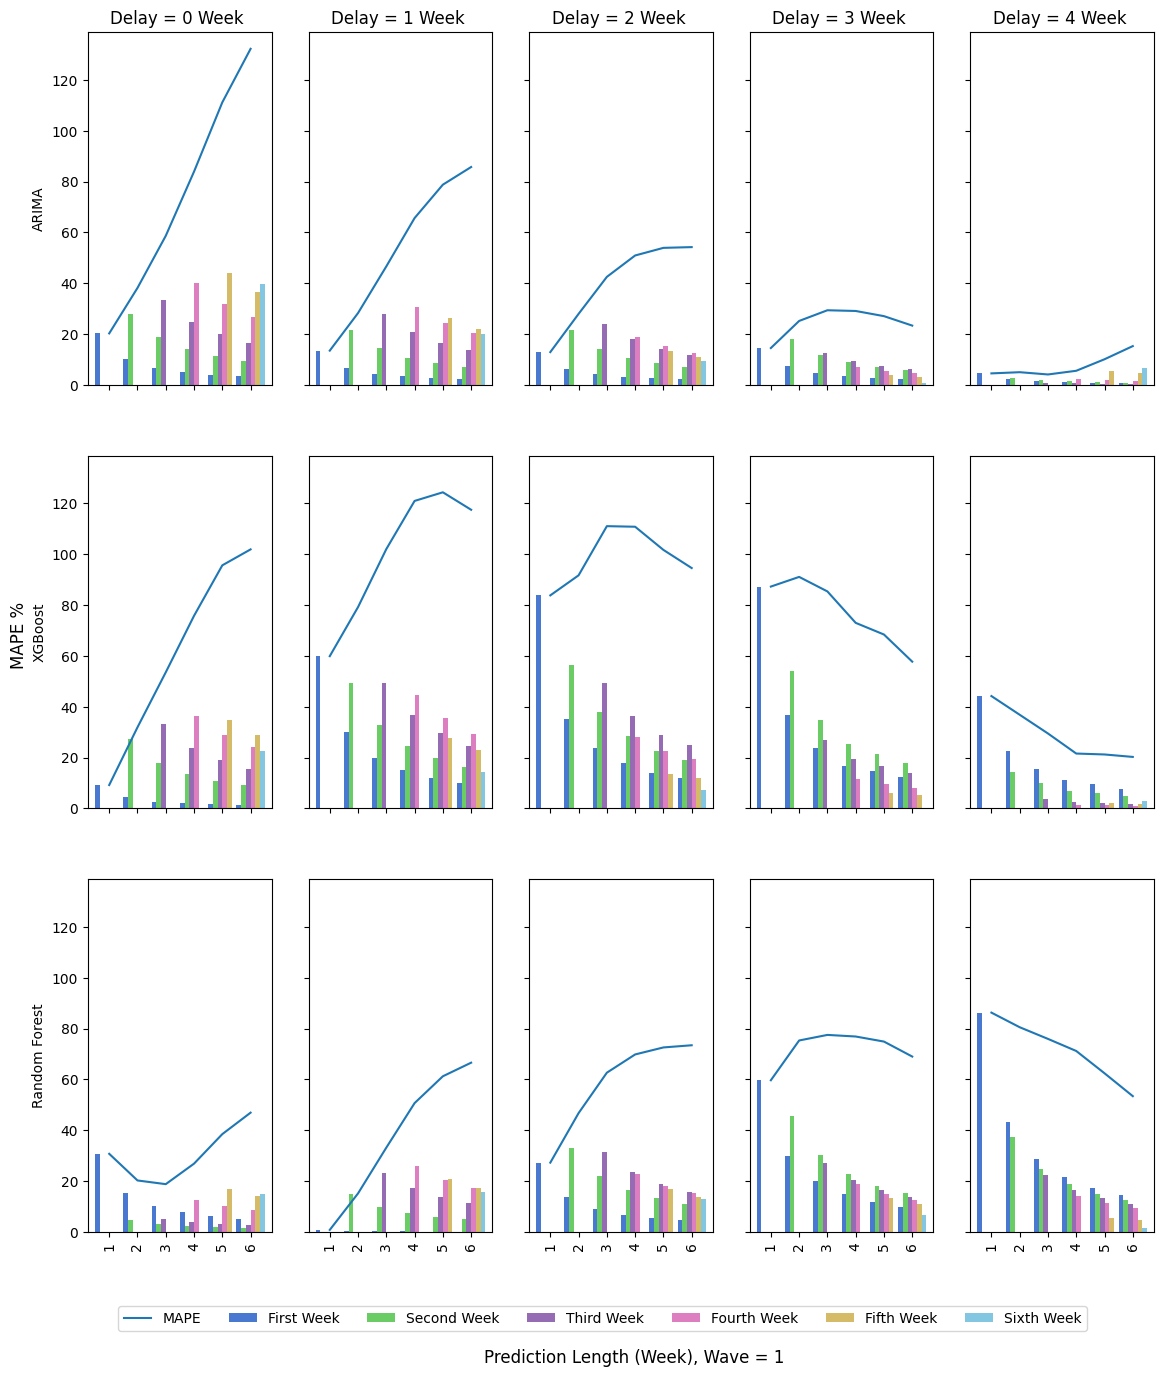

<Figure size 2500x1000 with 0 Axes>

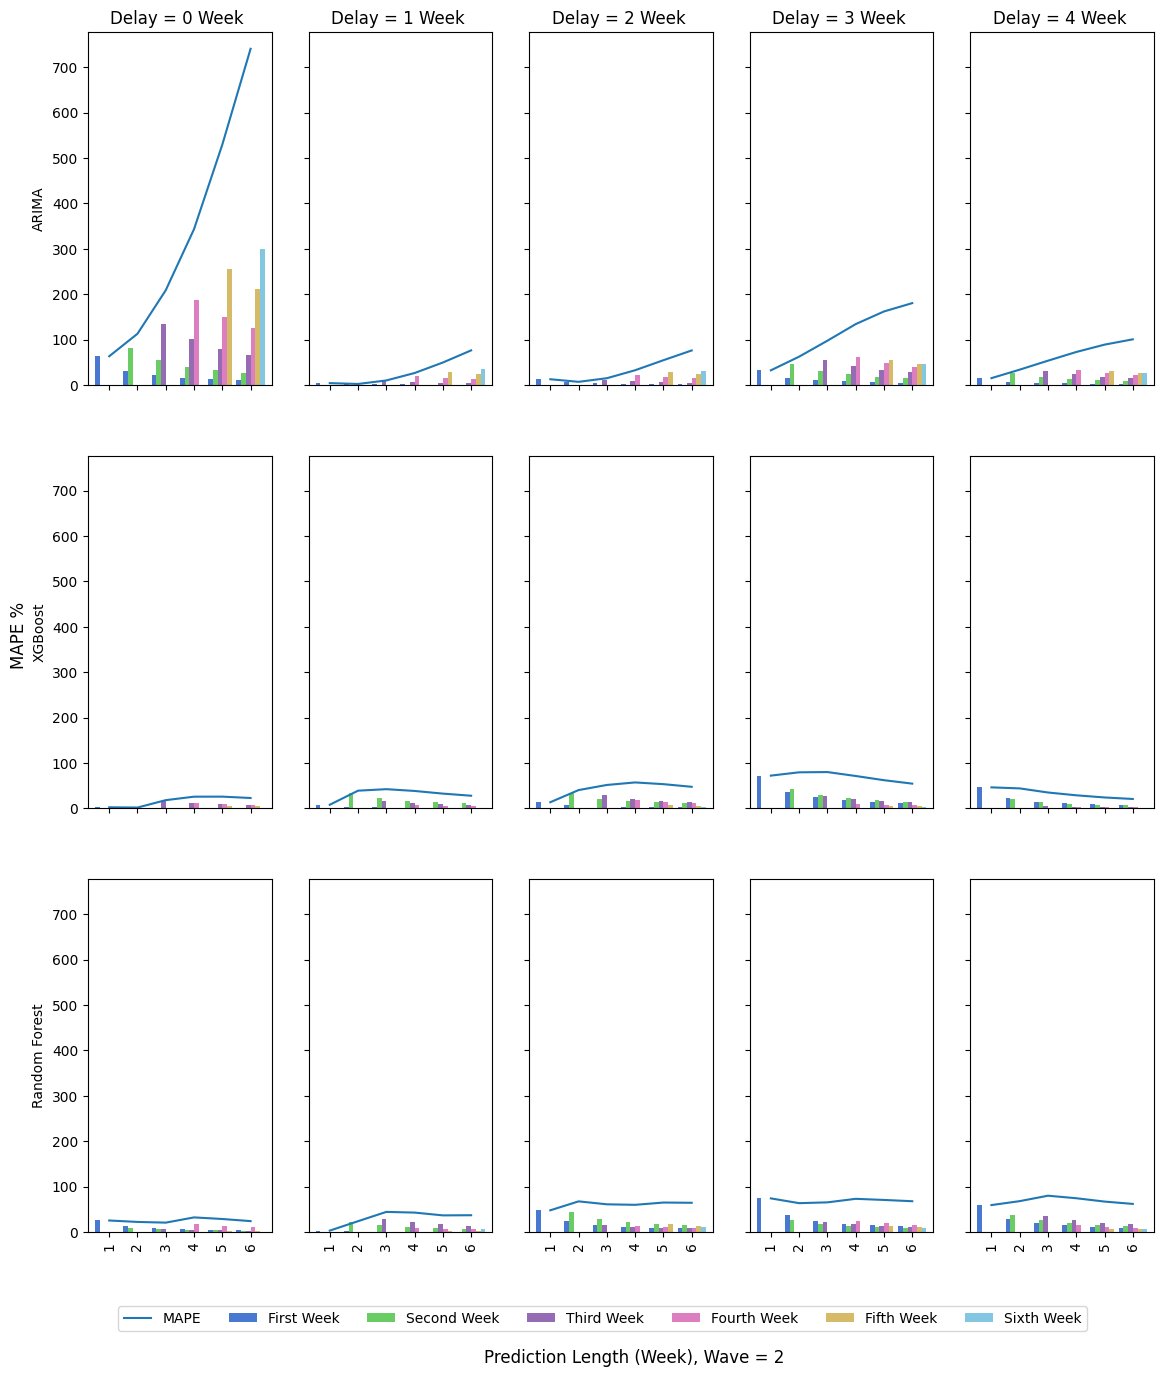

<Figure size 2500x1000 with 0 Axes>

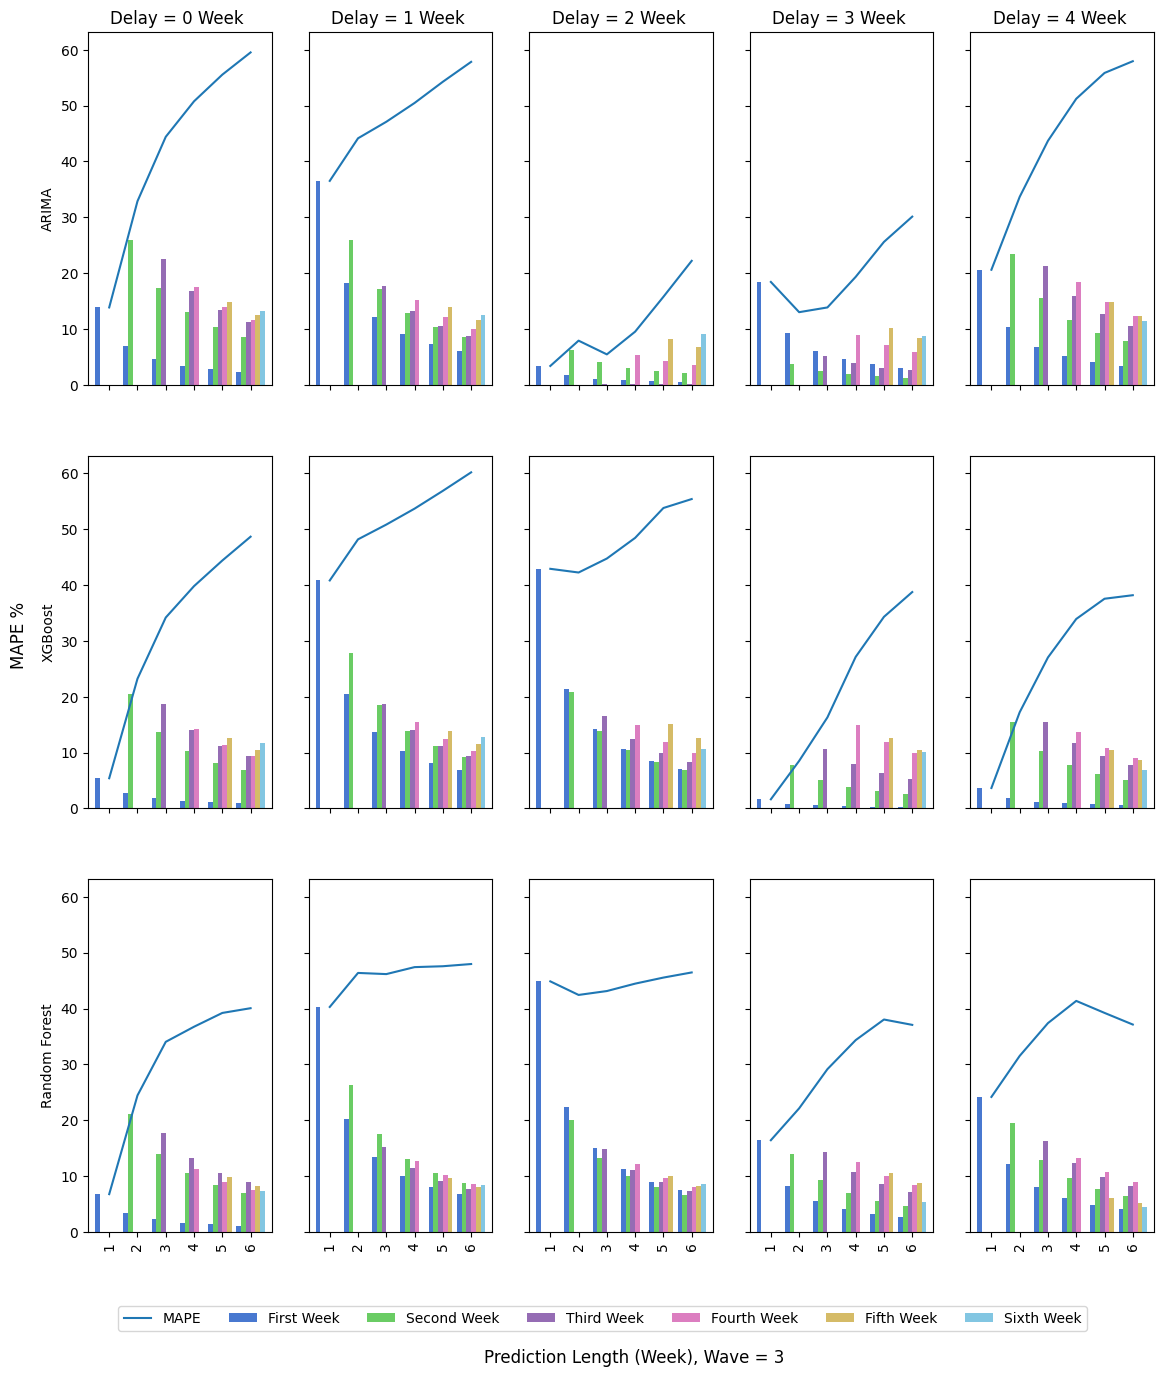

In [ ]:
mape_wave_delay = {}

for WAVE in WAVES:#[wave2d0]:#
  waveID = WAVE.waveID

  fig = plt.figure(figsize = (25,10))
  fig, axes = plt.subplots(3, 5, sharex=True, sharey = True)
  gs = fig.add_gridspec(3, 5, hspace=0.2, wspace=0.2)

  ARIMA = 0
  RF = 2
  XGB = 1


  for delay in delay_list:
    mape_delay = pd.DataFrame()
    print('DELAY:', delay)
    ax_arima = axes[ARIMA, delay]#fig.add_subplot(gs[ARIMA, delay])
    ax_xgb = axes[XGB, delay]#fig.add_subplot(gs[XGB, delay])
    ax_rf = axes[RF, delay]#fig.add_subplot(gs[RF, delay])

    plt.subplots_adjust(left= 0.08, right=0.9, top=0.9, bottom=0.1)

    df_arima_list_all_week_delay_collection = df_arima_list_all_week_delay_wave_collection[waveID]
    df_xgb_resid_list_all_week_delay_collection = df_xgb_resid_list_all_week_delay_wave_collection[waveID]
    df_xgb_list_all_week_delay_collection = df_xgb_list_all_week_delay_wave_collection[waveID]
    df_rf_list_all_week_delay_collection = df_rf_list_all_week_delay_wave_collection[waveID]

    all_week_arima_listTTT, values_arima_list = find_model_week_values_sum_delay(df_arima_list_all_week_delay_collection, delay, weeks)
    values_arima_df = pd.DataFrame(values_arima_list)
    values_arima_df.columns = ['ARIMA']

    all_week_arima_listTTT.plot(kind='bar', stacked=False, width = 1,
            colormap=ListedColormap(sns.color_palette("muted", 10)),
            figsize=(13,15), ax = ax_arima)
    ax_arima.plot(values_arima_list,label="MAPE")
    ax_arima.set_title("Delay = "+str(delay)+" Week ")
    ax_arima.get_legend().remove()
    #ax_arima.set_ylabel("Delay"+str(week)+"weeks",labelpad =2)


    all_week_xgb_resid_listTTT, values_xgb_resid_list = find_model_week_values_sum_delay(df_xgb_resid_list_all_week_delay_collection, delay, weeks)
    values_xgb_resid_df = pd.DataFrame(values_xgb_resid_list)
    values_xgb_resid_df.columns = ['XGBoost ARIMA Ensemble']

    all_week_xgb_listTTT, values_xgb_list = find_model_week_values_sum_delay(df_xgb_list_all_week_delay_collection, delay, weeks)
    values_xgb_df = pd.DataFrame(values_xgb_list)
    values_xgb_df.columns = ['XGBoost']
    all_week_xgb_listTTT.plot(kind='bar', stacked=False, width = 1,
            colormap=ListedColormap(sns.color_palette("muted", 10)),
            figsize=(13,15), ax = ax_xgb)
    ax_xgb.plot(values_xgb_list,label="MAPE")
    ax_xgb.get_legend().remove()

    all_week_rf_listTTT, values_rf_list = find_model_week_values_sum_delay(df_rf_list_all_week_delay_collection, delay, weeks)
    values_rf_df = pd.DataFrame(values_rf_list)
    values_rf_df.columns = ['Random Forest']
    all_week_rf_listTTT.plot(kind='bar', stacked=False, width = 1,
            colormap=ListedColormap(sns.color_palette("muted", 10)),
            figsize=(13,15), ax = ax_rf)
    ax_rf.plot(values_rf_list,label="MAPE")
    ax_rf.get_legend().remove()

    mape_delay = pd.concat([values_arima_df, values_xgb_resid_df, values_xgb_df, values_rf_df], axis=1, join='inner')#, join='inner' lagbe naki janina check later
    mape_wave_delay[waveID] = mape_delay

    if (delay==0):
      ax_rf.set(ylabel = "Random Forest")
      ax_xgb.set(ylabel = "XGBoost")
      ax_arima.set(ylabel = "ARIMA")
    if (delay==len(delay_list)-1):

      # ax3.set_yscale('log')
      # ax3.sharey(ax1)
      ax_rf.legend(["MAPE",'First Week','Second Week', 'Third Week','Fourth Week','Fifth Week','Sixth Week'],loc='lower center', bbox_to_anchor=(-2,-.3),ncol = 7)

      # ax4.set_yscale('log')
      # ax4.sharey(ax1)
    fig.supxlabel("Prediction Length (Week), Wave = "+str(waveID))
    fig.supylabel("MAPE % " )


In [ ]:
mape_wave_delay

In [ ]:
#wave 2

In [ ]:

# # #### Cross Validation for ARIMA model abcde
# ARMAmodel_delay1 = SARIMAX(single_train_1_delay1, order=(2, 0, 0), seasonal_order=(0, 0, 0, 52)) wave 1 all delay
# ARMAmodel = SARIMAX(single_train_1,order=(2,0,1),seasonal_order=(0,0,0,52))# wave 2, order 1 dealy 0 1 2 3 4
# ARMAmodel = SARIMAX(single_train_6,order=(2,0,1),seasonal_order=(0,0,0,52)) wave 3 order 1, for delay 0 1
# ARMAmodel_delay2 = SARIMAX(single_train_1_delay2, order=(2, 0, 0), seasonal_order=(0, 0, 0, 52)) wave 3 order 0 delay 2 3 4

# ### Generate Machine Learning Data

# RF_model = RandomForestRegressor(max_depth = 6, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 50,random_state= 42).fit(train_x,train_y) for wave 2 delay 0
# RF_model_delay1 = RandomForestRegressor(max_depth = 6, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 40,random_state= 42).fit(train_x_delay1, train_y_delay1) wave 2 delay 1
# RF_model_delay4 = RandomForestRegressor(max_depth = 9, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 100,random_state= 42).fit(train_x_delay4, train_y_delay4) wave 2 delay 4
# RF_model_delay3 = RandomForestRegressor(max_depth = 2, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 40,random_state= 42).fit(train_x_delay3, train_y_delay3) wave 2 delay 3
# RF_model_delay2 = RandomForestRegressor(max_depth = 5, max_features= 'sqrt',min_samples_split = 3,  n_estimators= 50,random_state= 42).fit(train_x_delay2, train_y_delay2) wave 2 delay 2
# #### Random Forest Model
# RF_model_delay1 = RandomForestRegressor(max_depth = 4, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 50,random_state= 42).fit(train_x_delay1, train_y_delay1) for wave1 delay 1
# RF_model = RandomForestRegressor(max_depth = 5, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 40,random_state= 42).fit(train_x,train_y) wave 1, delay 0
# RF_model_delay2 = RandomForestRegressor(max_depth = 3, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 40,random_state= 42).fit(train_x_delay2, train_y_delay2) wave 1 delay 2
# RF_model_delay3 = RandomForestRegressor(max_depth = 3, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 50,random_state= 42).fit(train_x_delay3, train_y_delay3) wave 1 delay 3
# RF_model_delay4 = RandomForestRegressor(max_depth = 2, max_features= 'sqrt',min_samples_split = 9,  n_estimators= 50,random_state= 42).fit(train_x_delay4, train_y_delay4) wave 1 delay 4

# RF_model = RandomForestRegressor(max_depth = 8, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 25,random_state= 42).fit(train_x,train_y) wave 3 delay 0
# RF_model_delay1 = RandomForestRegressor(max_depth = 8, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 25,random_state= 42).fit(train_x_delay1, train_y_delay1) wave 3 delay 1
# RF_model_delay2 = RandomForestRegressor(max_depth = 10, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 50,random_state= 42).fit(train_x_delay2, train_y_delay2) wave 3 delay 2
# RF_model_delay3 = RandomForestRegressor(max_depth = 10, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 50,random_state= 42).fit(train_x_delay3, train_y_delay3) wave 3 delay 3
# RF_model_delay4 = RandomForestRegressor(max_depth = 9, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 20,random_state= 42).fit(train_x_delay4, train_y_delay4) wave 3 delay 4
# #### XGBoost Model

# xgb_1=  XGBRegressor(booster = "dart", learning_rate = 0.3, n_estimators = 10).fit(train_x,train_y) wave 2 dart delay 0
# xgb_1_delay1=  XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay1, train_y_delay1) wave 2, delay 1
# xgb_6_delay4=  XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay4, train_y_delay4) wave 2 delay 4
# xgb_6_delay3= XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay3, train_y_delay3) wave 2 delay 3
# xgb_5_delay2=  XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay2, train_y_delay2) wave 2 delay 2

# xgb_1_delay1=  XGBRegressor(booster = "gbtree", learning_rate = 0.05, n_estimators = 2).fit(train_x_delay1, train_y_delay1) wave 1 delay 1
# xgb_6=  XGBRegressor(booster = "gbtree", learning_rate = 0.05, n_estimators = 2).fit(train_x,train_y) wave 1 delay 0
# xgb_1_delay2=  XGBRegressor(booster = "gblinear", learning_rate = 0.2, n_estimators = 30).fit(train_x_delay2, train_y_delay2) wave 1 delay 2
# xgb_1_delay3=  XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 10).fit(train_x_delay3, train_y_delay3) wave 1 delay 3
# xgb_4_delay4=  XGBRegressor(booster = "gbtree", learning_rate = 0.05, n_estimators = 2).fit(train_x_delay4, train_y_delay4)wave 1 delay 4

# xgb_6=  XGBRegressor(booster = "dart", learning_rate = 0.2, n_estimators = 30).fit(train_x,train_y) wave 3 delay 0
# xgb_5_delay1=  XGBRegressor(booster = "dart", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay1, train_y_delay1) wave 3 delay 1
# xgb_1_delay2=  XGBRegressor(booster = "dart", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay2, train_y_delay2) wave 3 delay 2
# xgb_1_delay3=  XGBRegressor(booster = "gbtree", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay3, train_y_delay3) wave 3 delay 3
# xgb_1_delay4=  XGBRegressor(booster = "dart", learning_rate = 0.3, n_estimators = 30).fit(train_x_delay4, train_y_delay4) wave 3 delay 4

# #### XGBoost On ARIMA residual
# xgb_resid_1, xgb_resid_predict1,arima, xgb_resid_list_1 = arima_res_xgb(ARMAmodel, pd.DataFrame(wave2.weekcase),single_train_1,1,single_test_1,27,5,resid = True, booster = "dart", learning_rate = 0.05, n_estimator = 15) wave 2 both dart
# xgb_resid_1_delay1, xgb_resid_predict1_delay1,arima_delay1, xgb_resid_list_1_delay1 = arima_res_xgb(ARMAmodel_delay1, pd.DataFrame(wave2_delay1.weekcase), single_train_1_delay1, 1, single_test_1_delay1, 27, 5, resid = True, booster = "gbtree", learning_rate = 0.1, n_estimator = 20) wave 2 delay 1
# xgb_resid_6_delay4, xgb_resid_predict1_delay4,arima_delay4, xgb_resid_list_6_delay4 = arima_res_xgb(ARMAmodel_delay4, pd.DataFrame(wave2_delay4.weekcase), single_train_6_delay4, 6, single_test_6_delay4, 32, 5, resid = True, booster = "dart", learning_rate = 0.2, n_estimator = 5) wave 2 delay 4
# xgb_resid_6_delay3, xgb_resid_predict1_delay3,arima_delay3, xgb_resid_list_6_delay3 = arima_res_xgb(ARMAmodel_delay3, pd.DataFrame(wave2_delay3.weekcase), single_train_6_delay3, 6, single_test_6_delay3, 32, 5, resid = True,booster = "gblinear", learning_rate = 0.15, n_estimator = 2) wave 2 delay 3
# xgb_resid_5_delay2, xgb_resid_predict1_delay2,arima_delay2, xgb_resid_list_5_delay2 = arima_res_xgb(ARMAmodel_delay2, pd.DataFrame(wave2_delay2.weekcase), single_train_5_delay2, 5, single_test_5_delay2, 31, 5, resid = True,booster = "gbtree", learning_rate = 0.3, n_estimator = 3) wave 2 delay 2
# #### XGBoost On ARIMA residual
# xgb_resid_1_delay1, xgb_resid_predict1_delay1,arima_delay1, xgb_resid_list_1_delay1 = arima_res_xgb(ARMAmodel_delay1, pd.DataFrame(wave1_delay1.weekcase), single_train_1_delay1, 1, single_test_1_delay1, 27, 5, resid = True, booster = "dart", learning_rate = 0.05, n_estimator = 2) wave 1
# xgb_resid_6, xgb_resid_predict1,arima, xgb_resid_list_6 = arima_res_xgb(ARMAmodel, pd.DataFrame(wave1.weekcase),single_train_6,6,single_test_6,32,5,resid = True, booster = "gbtree", learning_rate = 0.05, n_estimator = 2) wave 1 delay
# xgb_resid_1_delay2, xgb_resid_predict1_delay2,arima_delay2, xgb_resid_list_1_delay2 = arima_res_xgb(ARMAmodel_delay2, pd.DataFrame(wave1_delay2.weekcase), single_train_1_delay2, 1, single_test_1_delay2, 27, 5, resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 2) wave 1 delay 2
# xgb_resid_1_delay3, xgb_resid_predict1_delay3,arima_delay3, xgb_resid_list_1_delay3 = arima_res_xgb(ARMAmodel_delay3, pd.DataFrame(wave1_delay3.weekcase), single_train_1_delay3, 1, single_test_1_delay3, 27, 5, resid = True, booster = "gbtree", learning_rate = 0.1, n_estimator = 2) wave 1 delay 3
# xgb_resid_4_delay4, xgb_resid_predict1_delay4,arima_delay4, xgb_resid_list_4_delay4 = arima_res_xgb(ARMAmodel_delay4, pd.DataFrame(wave1_delay4.weekcase), single_train_4_delay4, 4, single_test_4_delay4, 30, 5, resid = True, booster = "gbtree", learning_rate = 0.05, n_estimator = 2) wave 1 delay 4

# xgb_resid_6, xgb_resid_predict1,arima, xgb_resid_list_6 = arima_res_xgb(ARMAmodel, pd.DataFrame(wave3.weekcase),single_train_6,6,single_test_6,32,5,resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 2) wave 3 delay 0
# xgb_resid_5_delay1, xgb_resid_predict1_delay1,arima_delay1, xgb_resid_list_5_delay1 = arima_res_xgb(ARMAmodel_delay1, pd.DataFrame(wave3_delay1.weekcase), single_train_5_delay1, 5, single_test_5_delay1, 31, 5, resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 2) wave 3 delay 1
# xgb_resid_1_delay2, xgb_resid_predict1_delay2,arima_delay2, xgb_resid_list_1_delay2 = arima_res_xgb(ARMAmodel_delay2, pd.DataFrame(wave3_delay2.weekcase), single_train_1_delay2, 1, single_test_1_delay2, 27, 5, resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 2) wave 3 delay 2
# xgb_resid_1_delay3, xgb_resid_predict1_delay3,arima_delay3, xgb_resid_list_1_delay3 = arima_res_xgb(ARMAmodel_delay3, pd.DataFrame(wave3_delay3.weekcase), single_train_1_delay3, 1, single_test_1_delay3, 27, 5, resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 3) wave 3 delay 3
# xgb_resid_1_delay4, xgb_resid_predict1_delay4,arima_delay4, xgb_resid_list_1_delay4 = arima_res_xgb(ARMAmodel_delay4, pd.DataFrame(wave3_delay4.weekcase), single_train_1_delay4, 1, single_test_1_delay4, 27, 5, resid = True, booster = "gblinear", learning_rate = 0.05, n_estimator = 2) wave 3 delay 4








In [ ]:
#### Predict last two weeks using only wave 3 data
wave_task1 = df.loc['2022-02-20':'2023-10-15']
train_task1 = df.loc['2022-02-20':'2023-10-01']
wave_task2 = df.loc['2021-02-28':'2023-10-15']
train_task2 = df.loc['2021-02-28':'2023-10-01']
wave_task3 = df.loc['2020-01-12':'2023-10-15']
train_task3 = df.loc['2020-01-12':'2023-10-01']

test = df.loc['2023-10-08':'2023-10-15']

In [ ]:
wave3t1 = Wave(31,'2022-02-20', '2023-10-15', '2022-02-20', '2023-10-01', '2023-10-08', '2023-10-15', df)#Wave 3 task 1

wave3t2 = Wave(32,'2021-02-28', '2023-10-15', '2021-02-28', '2023-10-01', '2023-10-08', '2023-10-15', df)#Wave 3 task 2

wave3t3 = Wave(32,'2020-01-12', '2023-10-15', '2020-01-12', '2023-10-01', '2023-10-08', '2023-10-15', df)#Wave 3 task 3

wave3tasks = [wave3t1, wave3t2, wave3t3]

In [ ]:
arima_order = (2,0,0)
arima_seasonal_order = (0,0,0,52)
prediction_length = 2
#waveID = 1
delay = 0

metrics_df_wave3tasks = pd.DataFrame(columns=COLUMN_NAMES)
xgb_task = {}
arima_task = {}
rf_task = {}

tasks = {}

for WAVE in wave3tasks:
  waveID = WAVE.waveID
  for tuned_model_name in tuned_model_names:
    wave_delay_model_key = 'wave '+str(3)+' delay '+str(delay)+tuned_model_name
    wave_delay_tuned_params[tuned_model_name]=tuned_model_dict[wave_delay_model_key]
  #print(wave_delay_tuned_params)
  wave, train, test = WAVE.get_wave_dates_with_delay(delay)
  xgb, rf, xgb_resid, xgb_resid_predict, arima, arima_mape, xgb_resid_mape, xgb_mape, rf_mape, arima_list, RF_list, xgb_list, xgb_resid_list =  wave_prediction(
      prediction_length, wave, train, test, wave_delay_tuned_params)

  xgb = xgb.reset_index(drop = True)
  rf = rf.reset_index(drop = True)
  xgb_resid = xgb_resid.reset_index(drop = True)
  arima = arima.reset_index(drop = True)

  xgb_task[waveID] = xgb_mape
  arima_task[waveID] = arima_mape
  rf_task[waveID] = rf_mape
  task = pd.concat([arima[-28:].reset_index(drop = True),xgb.reset_index(drop = True), df.weekcase[-30:-2].reset_index(drop = True)],axis = 1)
  task.columns = ["ARIMA", "XGBoost","real"]
  task.index = df[-28:].index

  tasks[waveID] = task

  data = { 'wave': waveID, 'delay': delay, 'prediction_length':prediction_length,'xgb': [xgb], 'rf': [rf], 'xgb_resid': [xgb_resid], 'xgb_resid_predict': [xgb_resid_predict],'arima': [arima], 'xgb_resid_mape': [xgb_resid_mape], 'xgb_mape':[xgb_mape], 'arima_list' : [arima_list], 'RF_list':[RF_list], 'xgb_list':[xgb_list], 'xgb_resid_list': [xgb_resid_list]}
  #print(data)
  newrow = pd.DataFrame(data)
  #print(newrow.size)
  metrics_df_wave3tasks = pd.concat([metrics_df_wave3tasks, newrow])#, ignore_index=True





In [ ]:
### 3 weekDLT
single_train_task_3, full_train_task_3 = stats_data(train_task3)
### 3 week
single_test_task_3, full_test_task_3 = stats_data(test)
ARMAmodel_task_3 = SARIMAX(single_train_task_3, order=(2, 0, 1), seasonal_order=(0, 0, 0, 52))
arima_mse_task_3,arima_rmse_task_3,arima_mae_task_3,arima_mape_task_3,arima_list_task_3,arima_task_3 = ARIMA_model(ARMAmodel_task_3, single_test_task_3, 31, len(single_test_task_3))

### Generate Machine Learning Data
train_x_task_3,test_x_task_3,train_y_task_3,test_y_task_3 = gen_ml(pd.DataFrame(wave_task1.weekcase), 2, 5, resid = False)
#### Random Forest Model
RF_model_task_3 = RandomForestRegressor(max_depth = 9, max_features= 'sqrt',min_samples_split = 2,  n_estimators= 25,random_state= 42).fit(train_x_task_3, train_y_task_3)
RF_list_task_3,rf_mse_task_3,rf_rmse_task_3,rf_mae_task_3,rf_mape_task_3 = ml_model(test_x_task_3, test_y_task_3, RF_model_task_3, train_task3)
rf_fit_task_3 = pd.DataFrame(RF_model_task_3.predict(train_x_task_3)).reset_index(drop = True).tail(26)
rf_pre_task_3 = pd.DataFrame(RF_model_task_3.predict(test_x_task_3)).reset_index(drop = True)
rf_task_3 = pd.concat([rf_fit_task_3, rf_pre_task_3], axis=0)

#### XGBoost Model
xgb_task_3=  XGBRegressor(booster = "gblinear", learning_rate = 0.3, n_estimators = 30).fit(train_x_task_3, train_y_task_3)
xgb_predict_task_3 = xgb_task_3.predict(test_x_task_3) #Predictions on test_5ing data
xgb_list_task_3 = np.abs(xgb_predict_task_3 - test_y_task_3) / test_y_task_3
xgb_p_task_3 =  pd.DataFrame(xgb_predict_task_3)
xgb_p_task_3 = xgb_p_task_3.reset_index(drop = True)
xgb_f_task_3 = xgb_task_3.predict(train_x_task_3)
xgb_f_task_3 = pd.DataFrame(xgb_f_task_3).tail(26)
xgb_f_task_3 = xgb_f_task_3.reset_index(drop=True)
xgb_task_3 = pd.concat([xgb_f_task_3, xgb_p_task_3], axis=0)
xgb_mape_task_3 = mean_absolute_percentage_error(wave_task3.weekcase[-len(xgb_predict_task_3):].values, xgb_predict_task_3[:])


In [ ]:
#DLT
xgb_task = [xgb_mape_task_1, xgb_mape_task_2, xgb_mape_task_3]
arima_task= [arima_mape_task_1, arima_mape_task_2, arima_mape_task_3]
rf_task = [rf_mape_task_1, rf_mape_task_2, rf_mape_task_3]

In [ ]:
#DLT
task3 = pd.concat([arima_task_3[-28:].reset_index(drop = True),xgb_task_3.reset_index(drop = True), df.weekcase[-30:-2].reset_index(drop = True)],axis = 1)
task3.columns = ["ARIMA", "XGBoost","real"]
task3.index = df[-28:].index
task1 = pd.concat([arima_task_1[-28:].reset_index(drop = True),xgb_task_1.reset_index(drop = True), df.weekcase[-30:-2].reset_index(drop = True)],axis = 1)
task1.columns = ["ARIMA", "XGBoost","real"]
task1.index = df[-28:].index
task2 = pd.concat([arima_task_2[-28:].reset_index(drop = True),xgb_task_2.reset_index(drop = True), df.weekcase[-30:-2].reset_index(drop = True)],axis = 1)
task2.columns = ["ARIMA", "XGBoost","real"]
task2.index = df[-28:].index

Text(0.02, 0.5, 'Covid Cases')

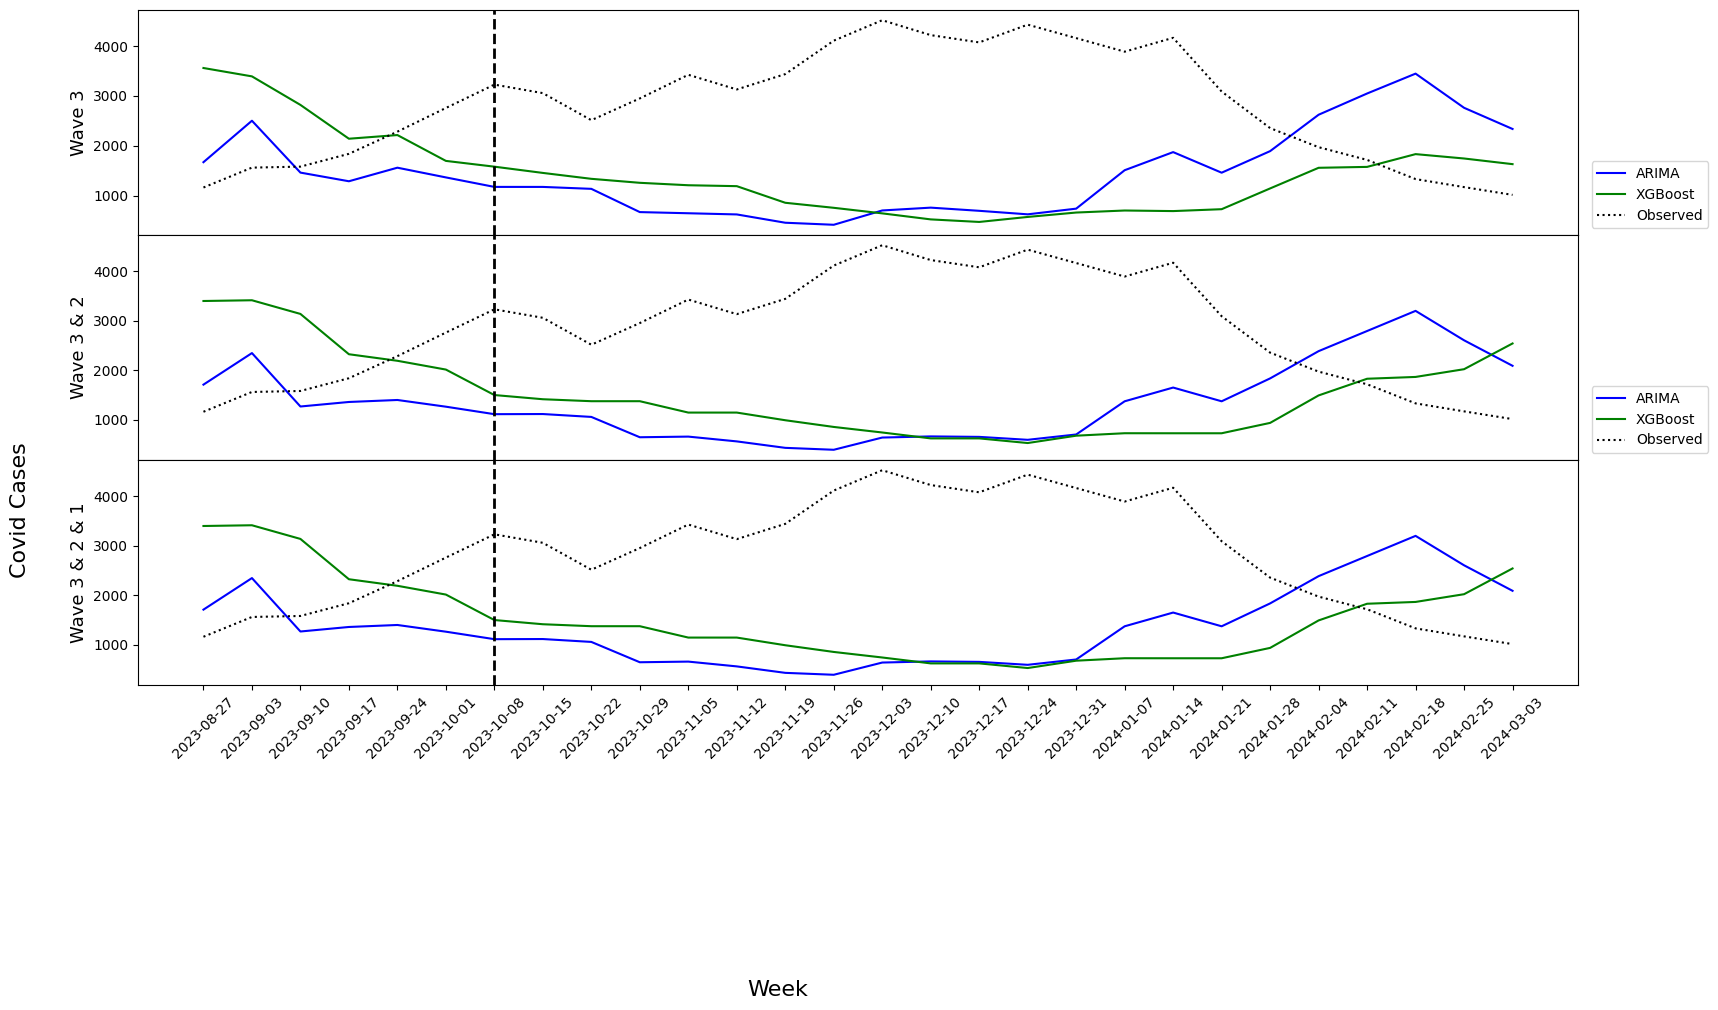

In [ ]:
fig = plt.figure(figsize=(16, 10))
plt.subplots_adjust(left=0.1, right=1, top=1, bottom=0.1)
gs = fig.add_gridspec(4,1, hspace=0, wspace=0)
i = 0

labels = ['', " & 2", " & 2 & 1"]
for WAVE in wave3tasks:#[wave2d0]:#
  waveID = WAVE.waveID

  time = WAVE.get_wave_df().tail(32).reset_index(drop = True)
  task = tasks[waveID]

  ax = fig.add_subplot(gs[i, 0])


  ax.plot(task.index, task['ARIMA'], label='ARIMA', color='blue')
  ax.plot(task.index, task['XGBoost'], label='XGBoost', color='green')
  # plt1.plot(task1.index, task1['Ensemble'], label='Ensemble', color='red')
  ax.plot(task.index, task['real'], label='Observed', color='black', linestyle='dotted')
  ax.set_ylabel("Wave 3"+labels[i], fontsize=13)

  i = i+1

  if(i>=2):
    ax.legend(loc='lower center', bbox_to_anchor=(1.05,1),ncol = 1)
    ax.set_xticklabels(task.index, rotation=45)
  ax.axvline('2023-10-08', color='black', linestyle='--', lw=2)

# Adding title and labels
fig.supxlabel('Week',fontsize=16)
fig.supylabel("Covid Cases", fontsize=16)

#plt.show()

In [ ]:
fig = plt.subplots(figsize=(16, 5))

# Adding a plot title and customizing its font size


# Adding axis labels and customizing their font size


# Rotaing axis ticks and customizing their font size
# plt.xticks(rotation=30, fontsize=12)

plt.plot(df.index, df['weekcase'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Covid-19 Case Count', fontsize=15)
plt.xlim(df.index.min(), df.index.max())
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::14]))
for label in temp:
    label.set_visible(False)
plt.xticks(rotation=30, fontsize=8)
plt.axvline('2021-02-21', color='black', linestyle='--', lw=2)
plt.axvline('2022-02-13', color='black', linestyle='--', lw=2)
plt.text(20, 80000, 'Wave 1', fontsize = 14)
plt.text(80, 80000, 'Wave 2', fontsize = 14)
plt.text(150, 80000, 'Wave 3', fontsize = 14)
plt.show()

In [ ]:
def gen_training(data,parameter_length):
    dataframe = pd.DataFrame()
    for i in range(parameter_length, 0, -1):
        dataframe['t+' + str(i)] = data.iloc[:, 0].shift(i)
    final_data = pd.concat([data,dataframe], axis=1)
    final_data.dropna(inplace=True)
    finaldf = final_data
    finaldf = finaldf.reset_index(drop=True)
    finaldf_y =  finaldf.iloc[:, 0]
    finaldf_x = finaldf.iloc[: , 1:]
    return finaldf_y,finaldf_x

In [ ]:
wave3 = WAVES[2]
# Model 1. ARIMA_model
weekcase, full = stats_data(wave3.df)
ARMAmodel = SARIMAX(weekcase,order=(0,1,1),seasonal_order=(0,0,0,52))
### d = 1, predict 6 weeks
ARMAmodel = ARMAmodel.fit()
# Predict 6 weeks
y_pred = ARMAmodel.get_forecast(6)
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_out = y_pred_df["Predictions"]
y_pred_out
arima_line = np.append(ARMAmodel.fittedvalues,y_pred_out)

In [ ]:
# def series_to_supervised(df, n_in=6, n_out=6, dropnan=True):
#  cols = list()
#  # input sequence (t-n, ... t-1)
#  for i in range(n_in, 0, -1):
#     cols.append(df.shift(i))
#  # forecast sequence (t, t+1, ... t+n)
#  for i in range(0, n_out):
#     cols.append(df.shift(-i))
#  # put it all together
#  agg = pd.concat(cols, axis=1)
#  # drop rows with NaN values
#  if dropnan:
#     agg.dropna(inplace=True)
#  return agg.values

# transform the time series data into supervised learning
trainy,trainx = gen_training(weekcase,5)

# fit model
model_rf = RandomForestRegressor(max_depth = 7, max_features= 'log2', n_estimators= 50)
model_rf.fit(trainx, trainy)
fit_rf = model_rf.predict(trainx)
# construct an input for a new prediction
predict_rf = []
row = weekcase.values[-5:].flatten()

for i in range(6):
    # make a one-step prediction
    yhat_rf = model_rf.predict(np.asarray([row]))
    predict_rf.append(yhat_rf)
    row = np.append(row, yhat_rf, axis=0)[-5:].flatten()
print(predict_rf)
rf_line = np.append(fit_rf,predict_rf)

In [ ]:
# fit model
model_xgb = XGBRegressor()
model_xgb.fit(trainx, trainy)
fit_xgb = model_xgb.predict(trainx)
# construct an input for a new prediction
predict_xgb = []
row = weekcase.values[-5:].flatten()
for i in range(6):
    # make a one-step prediction
    yhat_xgb = model_xgb.predict(np.asarray([row]))
    predict_xgb.append(yhat_xgb)
    row = np.append(row, yhat_xgb, axis=0)[-5:].flatten()

xgb_line = np.append(fit_xgb,predict_xgb)


real_line = np.append(trainy, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

In [ ]:

# Model ARIMA_xgboost
weekcase, full = stats_data(wave3.df)
ARMAmodel = SARIMAX(weekcase,order=(0,1,1),seasonal_order=(0,0,0,52))
### d = 1, predict 6 weeks
ARMAmodel = ARMAmodel.fit()
residual = pd.DataFrame(ARMAmodel.resid)
residual.column = ["weekcase"]
# transform the time series data into supervised learning
trainy_res,trainx_res = gen_training(residual,5)
# fit model
model_xgb_res = XGBRegressor()
model_xgb_res.fit(trainx_res, trainy_res)
fit_xgb_res = model_xgb_res.predict(trainx_res)
# construct an input for a new prediction
predict_xgb_res = []
row_res = residual.values[-5:].flatten()
for i in range(6):
    # make a one-step prediction
    yhat_xgb_res = model_xgb_res.predict(np.asarray([row_res]))
    predict_xgb_res.append(yhat_xgb_res)
    row_res = np.append(row, yhat_xgb_res, axis=0)[-5:].flatten()
print(np.array(predict_xgb_res).T[0])
#print(np.array(predict_xgb_res).T.tolist()[0])
xgb_res_line = np.append(ARMAmodel.fittedvalues[-77:].reset_index(drop = True)+fit_xgb_res, np.add(np.array(predict_xgb_res).T.tolist()[0], y_pred_out))
#xgb_res_line = np.append(ARMAmodel.fittedvalues[-77:].reset_index(drop = True)+fit_xgb_res, np.array(predict_xgb_res).T[0], y_pred_out)


In [ ]:
B = pd.DataFrame(
    {"real":real_line[-72:],
        'XGB':xgb_line[-72:],
     'RandomForest': rf_line[-72:],
     'ARIMA': arima_line[-72:],
     'XGBoost_ARIMA': xgb_res_line[-72:]
    })
B

In [ ]:
B = B_dict [3]

date = pd.Series(["2023-07-09", "2023-07-16", "2023-07-23", "2023-07-30","2023-08-06","2023-08-15"])
B = B.set_index(pd.Series(wave3.df.tail(66).index)._append(date))
B

In [ ]:
fig, ax = plt.subplots()
B.plot.line(ax = ax, use_index = True,rot = 90, y = 'real', color = 'blue', linewidth = 3, linestyle ='dotted')
B.plot.line(ax = ax, use_index = True,rot = 90,y = 'XGB', color = 'red', linewidth = 2, linestyle = 'solid')
B.plot.line(ax = ax, use_index = True,rot = 90,y = 'RandomForest', color = 'orange', linewidth = 1, linestyle = 'solid')
B.plot.line(ax = ax, use_index = True,rot = 90,y = 'ARIMA', color = 'green', linewidth = 1, linestyle = 'solid')
B.plot.line(ax = ax, use_index = True,rot = 90,y = 'XGBoost_ARIMA', color = 'magenta', linewidth = 1, linestyle = 'solid')
ax.set_xlabel("Week")
ax.set_ylabel("Weekly Covid Case")
ax.axvline(x = 65, color='grey',linestyle ="--")
plt.show()

In [ ]:

#JMM
import matplotlib.dates as mdates


def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Weekcases', dpi=100):
    fig = plt.figure(figsize=(15,4), dpi=dpi)
    ax = fig.add_subplot(1, 1, 1)


    plt.plot(x, y, color='tab:red')

    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.gcf().autofmt_xdate()

    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=8))



    plt.show()


plot_df(df, x=df_extended['week'], y=df_extended['weekcase'], title='Number of weekcase extended')


#JMM
fig, ax = plt.subplots(figsize=(15, 6))
df_extended['weekcase'].plot(kind="box", vert=False, title="Distribution of Weekcases",ax=ax);
#so many outliers?

#JMM
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

#JMM
check_stationarity(data)
#JMM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data, lags=70)
plot_pacf(data, lags=70)#AR=5 jowa uchit na or MA=3?, also no seasonal significant
plt.show()